# Columns Infos.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

# Imports

In [190]:
import math
import random
import pickle
import datetime
import warnings
import inflection
import pandas              as pd
import numpy               as np
import xgboost             as xgb
import seaborn             as sns
import matplotlib.pyplot   as plt

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor 
from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.6f}'.format
plt.rcParams['figure.figsize'] = [16, 10]

## Helper Functions

In [199]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['font.size'] = 18
    
    dusplay(HTML('<style>.container {width:100% !important;}</style'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

    
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae, 
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print(f'\nKfold Number: {k}')
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k -1) * 6 * 7)

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training and validation dataset
        # Training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str), 
         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)},
         index = [0])

## Loading Data

In [4]:
df_sales_raw = pd.read_csv('C:\\Users\\felip\\repos\\data_science_em_producao\\rossmann_data\\train.csv', low_memory = False)
df_store_raw = pd.read_csv('C:\\Users\\felip\\repos\\data_science_em_producao\\rossmann_data\\store.csv', low_memory = False)

### [Merge - join two DataFrames.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [5]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# Data Description

## Rename Columns

In [274]:
# Dataset copy
df1 = df_raw.copy()

In [7]:
cols_old = list(df1.columns)

In [8]:
df1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,"1,270.000000",9.000000,"2,008.000000",0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000000,11.000000,"2,007.000000",1,13.000000,"2,010.000000","Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,"14,130.000000",12.000000,"2,006.000000",1,14.000000,"2,011.000000","Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000000,9.000000,"2,009.000000",0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,"29,910.000000",4.000000,"2,015.000000",0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,"1,900.000000",6.000000,"2,014.000000",1,31.000000,"2,013.000000","Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,"1,880.000000",4.000000,"2,006.000000",0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,"9,260.000000",NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.000000,NaN,NaN,0,NaN,NaN,NaN


In [9]:
# Transforming columns names from CamelCase to SnakeCase.

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename columns
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [11]:
print(f'Number of Rows: {df1.shape[0]}.\nNumber of Columns: {df1.shape[1]}.')

Number of Rows: 1017209.
Number of Columns: 18.


## Data Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NaN

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NaN

The first method used, marked as a comment, was the method used by the instructor,
however, the "fillna ()" method is more efficient.

In [15]:
# competition_distance
    # I've assumed that the missing values on "competition_distance" column means that there are no competition 
    # near by the store, so I put a huge aleatory distance (bigger then oririnal max distance). 
    
# df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isna(x) else x)

df1['competition_distance'].fillna(200000, inplace = True)

# competition_open_since_month

# df1['competition_open_since_month'] = df1['competition_open_since_month'].apply(lambda x: x['date].month 
    # if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'])
    
df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace = True)

#competition_open_since_year  

# df1['competition_open_since_year'] = df1['competition_open_since_year'].apply(lambda x: x['date].year 
    # if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'])
    
df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace = True)

#promo2_since_week   

#df1['promo2_since_week'] = df1['promo2_since_week'].apply(lambda x: x['date].week 
    # if math.isnan(x['promo2_since_week']) else x['promo2_since_week'])

df1['promo2_since_week'].fillna(df1['date'].dt.week, inplace = True)

#promo2_since_year     

#df1['promo2_since_year'] = df1['promo2_since_year'].apply(lambda x: x['date].year 
    # if math.isnan(x['promo2_since_year']) else x['promo2_since_year'])

df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)

#promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

## Change Types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## Descriptive Statistical

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Numerical Attributes

In [18]:
df1.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
store,"1,017,209.000000",558.430000,321.910000,1.000000,280.000000,558.000000,838.000000,"1,115.000000"
day_of_week,"1,017,209.000000",4.000000,2.000000,1.000000,2.000000,4.000000,6.000000,7.000000
sales,"1,017,209.000000","5,773.820000","3,849.930000",0.000000,"3,727.000000","5,744.000000","7,856.000000","41,551.000000"
customers,"1,017,209.000000",633.150000,464.410000,0.000000,405.000000,609.000000,837.000000,"7,388.000000"
open,"1,017,209.000000",0.830000,0.380000,0.000000,1.000000,1.000000,1.000000,1.000000
promo,"1,017,209.000000",0.380000,0.490000,0.000000,0.000000,0.000000,1.000000,1.000000
school_holiday,"1,017,209.000000",0.180000,0.380000,0.000000,0.000000,0.000000,0.000000,1.000000
competition_distance,"1,017,209.000000","5,935.440000","12,547.650000",20.000000,710.000000,"2,330.000000","6,910.000000","200,000.000000"
competition_open_since_month,"1,017,209.000000",6.790000,3.310000,1.000000,4.000000,7.000000,10.000000,12.000000
competition_open_since_year,"1,017,209.000000","2,010.320000",5.520000,"1,900.000000","2,008.000000","2,012.000000","2,014.000000","2,015.000000"


[Skewness and Kurtosis definitions](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

**Skewness - degree of distortion**

        * -0.5 and 0.5, the data are fairly symmetrical.
        * -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.
        * less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.
        
**Kurtosis - measure of outliers**

        * >3 means that data are heavy-tailed or profusion of outliers.
        * <3 means that data are light-tailed or lack of outliers.
        * =3 means that the extreme values of the distribution are similar to that of a normal distribution characteristic.

In [19]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [20]:
display(num_attributes.describe().T)
display(cat_attributes.describe().T)

,count,mean,std,min,25%,50%,75%,max
store,"1,017,209.000000",558.429727,321.908651,1.000000,280.000000,558.000000,838.000000,"1,115.000000"
day_of_week,"1,017,209.000000",3.998341,1.997391,1.000000,2.000000,4.000000,6.000000,7.000000
sales,"1,017,209.000000","5,773.818972","3,849.926175",0.000000,"3,727.000000","5,744.000000","7,856.000000","41,551.000000"
customers,"1,017,209.000000",633.145946,464.411734,0.000000,405.000000,609.000000,837.000000,"7,388.000000"
open,"1,017,209.000000",0.830107,0.375539,0.000000,1.000000,1.000000,1.000000,1.000000
promo,"1,017,209.000000",0.381515,0.485759,0.000000,0.000000,0.000000,1.000000,1.000000
school_holiday,"1,017,209.000000",0.178647,0.383056,0.000000,0.000000,0.000000,0.000000,1.000000
competition_distance,"1,017,209.000000","5,935.442677","12,547.652996",20.000000,710.000000,"2,330.000000","6,910.000000","200,000.000000"
competition_open_since_month,"1,017,209.000000",6.786849,3.311087,1.000000,4.000000,7.000000,10.000000,12.000000
competition_open_since_year,"1,017,209.000000","2,010.324840",5.515593,"1,900.000000","2,008.000000","2,012.000000","2,014.000000","2,015.000000"


,count,unique,top,freq
state_holiday,1017209,4,0,986159
store_type,1017209,4,a,551627
assortment,1017209,3,a,537445
promo_interval,1017209,4,0,508031
month_map,1017209,12,May,103695


In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [22]:
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.000000,"1,115.000000","1,114.000000",558.429727,558.000000,321.908493,-0.000955,-1.200524
1,day_of_week,1.000000,7.000000,6.000000,3.998341,4.000000,1.997390,0.001593,-1.246873
2,sales,0.000000,"41,551.000000","41,551.000000","5,773.818972","5,744.000000","3,849.924283",0.641460,1.778375
3,customers,0.000000,"7,388.000000","7,388.000000",633.145946,609.000000,464.411506,1.598650,7.091773
4,open,0.000000,1.000000,1.000000,0.830107,1.000000,0.375539,-1.758045,1.090723
5,promo,0.000000,1.000000,1.000000,0.381515,0.000000,0.485758,0.487838,-1.762018
6,school_holiday,0.000000,1.000000,1.000000,0.178647,0.000000,0.383056,1.677842,0.815154
7,competition_distance,20.000000,"200,000.000000","199,980.000000","5,935.442677","2,330.000000","12,547.646829",10.242344,147.789712
8,competition_open_since_month,1.000000,12.000000,11.000000,6.786849,7.000000,3.311085,-0.042076,-1.232607
9,competition_open_since_year,"1,900.000000","2,015.000000",115.000000,"2,010.324840","2,012.000000",5.515591,-7.235657,124.071304


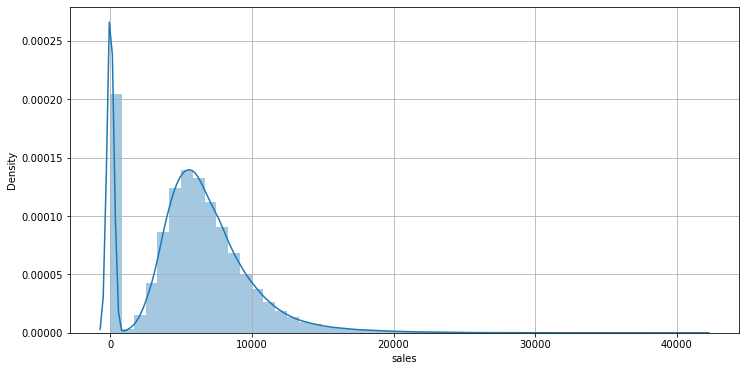

In [23]:
plt.figure(figsize = (12, 6))
sns.distplot(df1['sales'])
plt.grid()

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

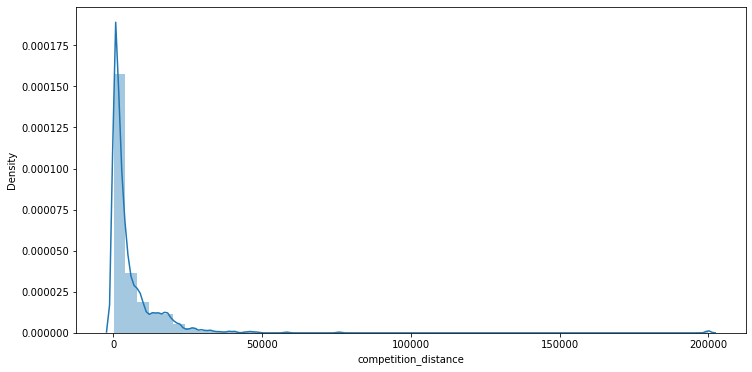

In [24]:
plt.figure(figsize = (12, 6))
sns.distplot(df1['competition_distance'])

## Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

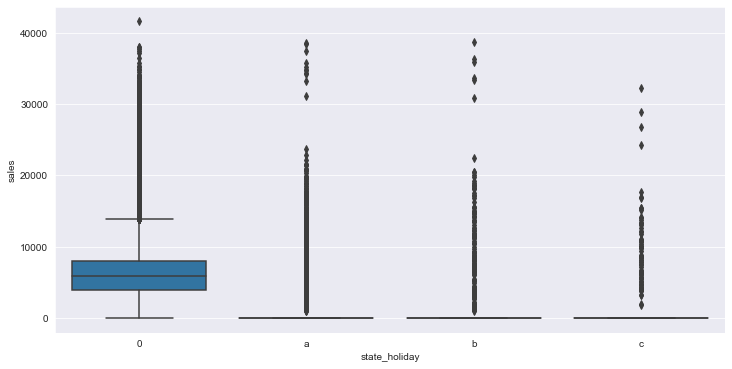

In [26]:
plt.figure(figsize = (12, 6))
sns.set_style("darkgrid")
sns.boxplot(x = 'state_holiday', y = 'sales', data = df1)

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

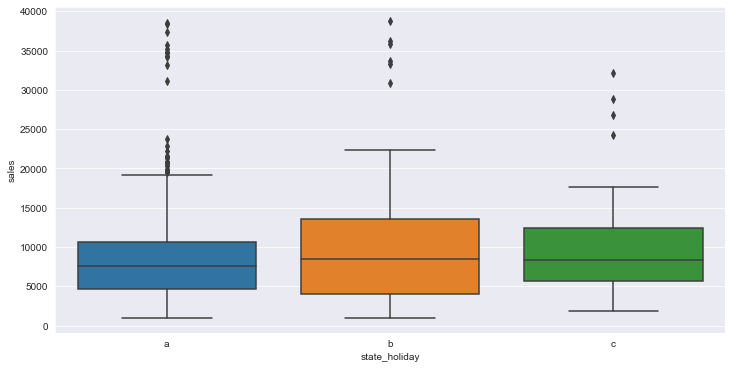

In [27]:
aux1 = df1[(df1['state_holiday'] != "0") & (df1['sales'] > 0)]
plt.figure(figsize = (12, 6))
sns.set_style("darkgrid")
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

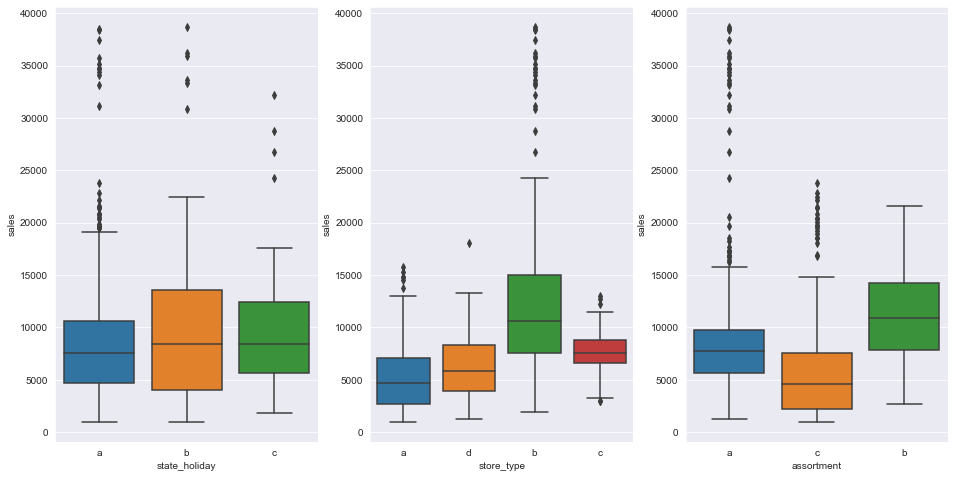

In [28]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

plt.show()

# Feature Enginnering


**uploading hypothesis mind map**

[coggle](https://coggle.it/)

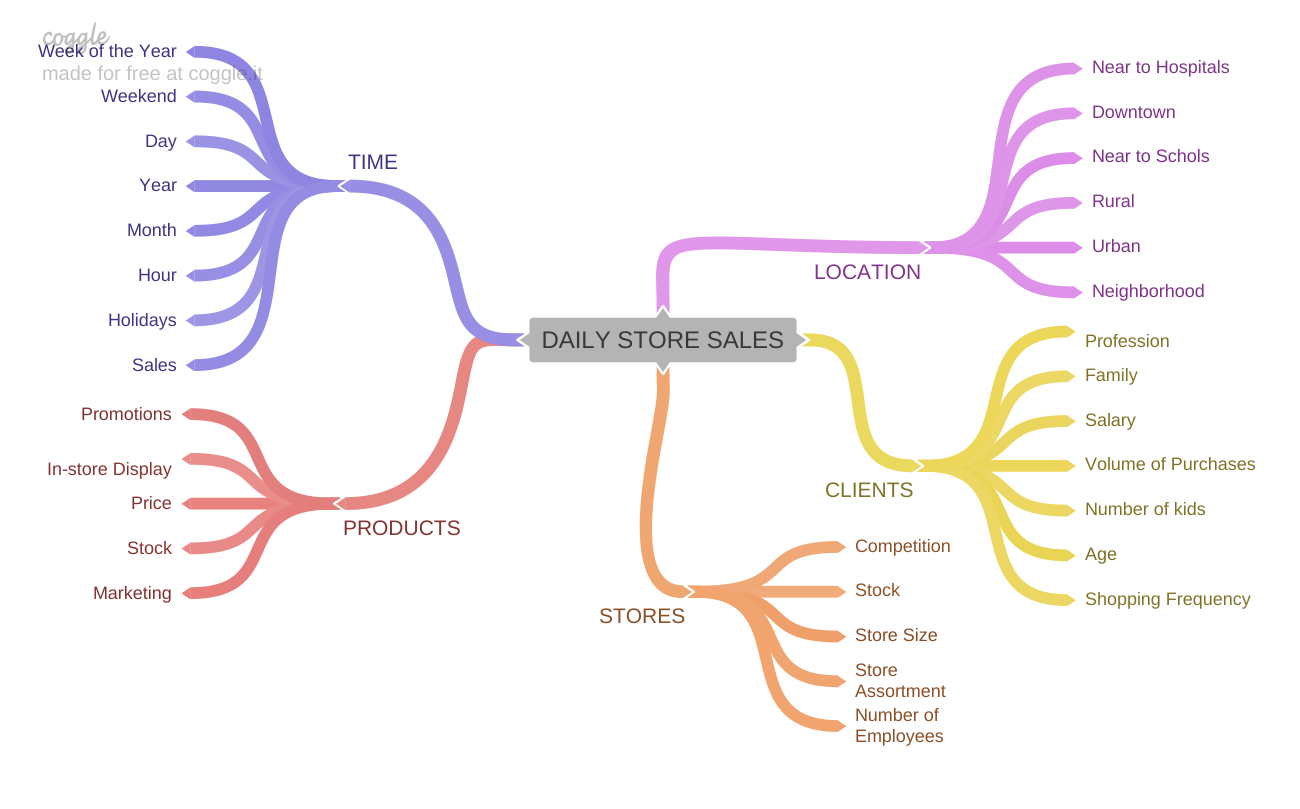

## Hypotesis Final List

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for a longer time should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less on school holidays.


In [29]:
df2 = df1.copy() 

## Feature Enginnering

In [30]:
# year
df2['year'] = df2.date.dt.year

# month
df2['month'] = df2.date.dt.month

# day
df2['day'] = df2.date.dt.day

# week of year
df2['week_of_year'] = df2.date.dt.weekofyear

# year week
df2['year_week'] = df2.date.dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## Filtering the Variables

In [31]:
df3 = df2.copy()
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## Rows Filtering

In [32]:
df3.shape

(1017209, 29)

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [34]:
df3.shape

(844338, 29)

## Columns Filtering

In [35]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [36]:
df3.shape

(844338, 25)

# Exploratory Data Analysis

In [37]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

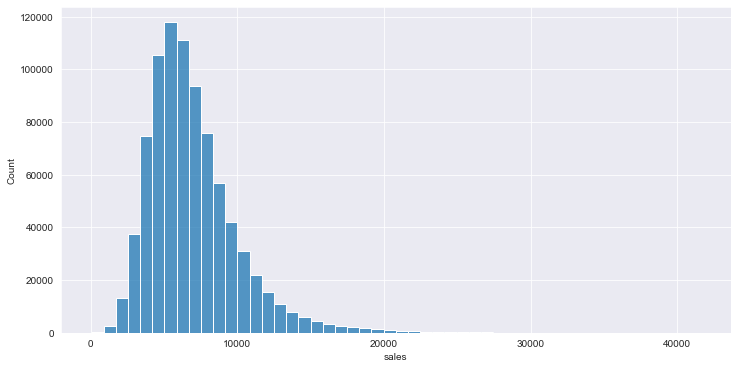

In [38]:
plt.figure(figsize = (12, 6))
sns.set_style('darkgrid')

sns.histplot(df4['sales'], kde = False, bins = 50);

### Numerical Variables

<Figure size 1152x432 with 0 Axes>

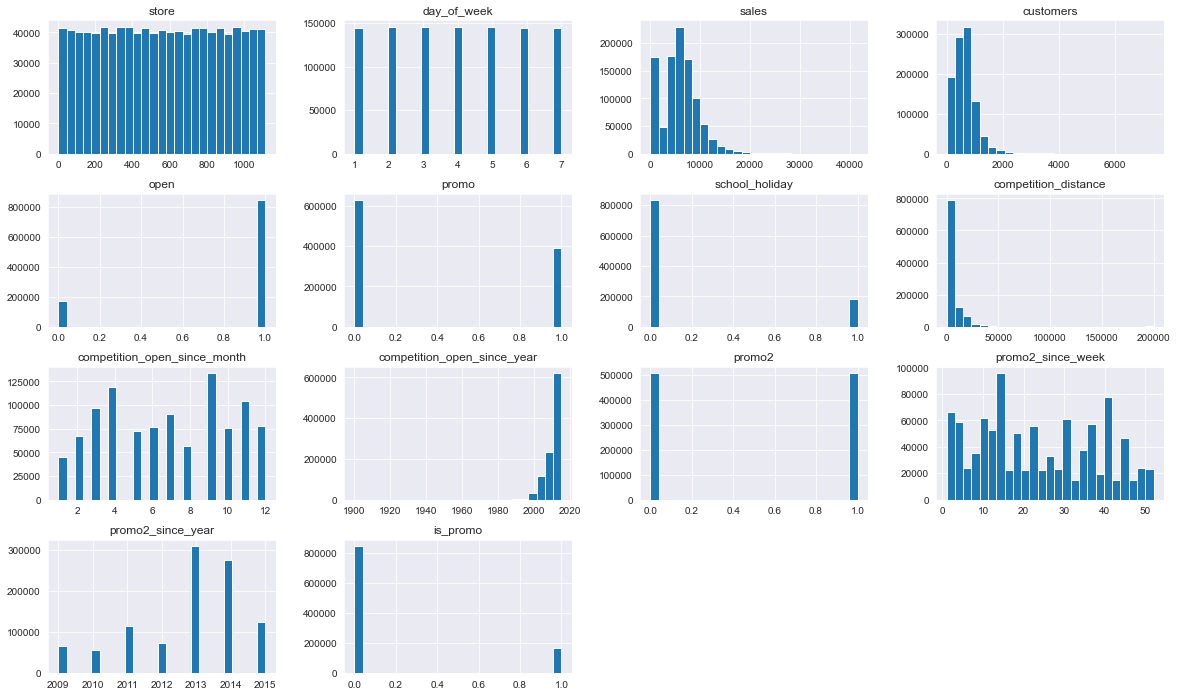

In [39]:
plt.figure(figsize = (16, 6))
num_attributes.hist(figsize = (20,12), bins = 25);

## Categorical Variables

In [40]:
display(df4['state_holiday'].drop_duplicates())
print('-=-'*30)
display(df4['store_type'].drop_duplicates())
print('-=-'*30)
display(df4['assortment'].drop_duplicates())

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


0     c
1     a
12    d
84    b
Name: store_type, dtype: object

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [41]:
display(df4['state_holiday'].value_counts())
print('-=-'*30)
display(df4['store_type'].value_counts())
print('-=-'*30)
display(df4['assortment'].value_counts())

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


a    457042
d    258768
c    112968
b     15560
Name: store_type, dtype: int64

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

[]

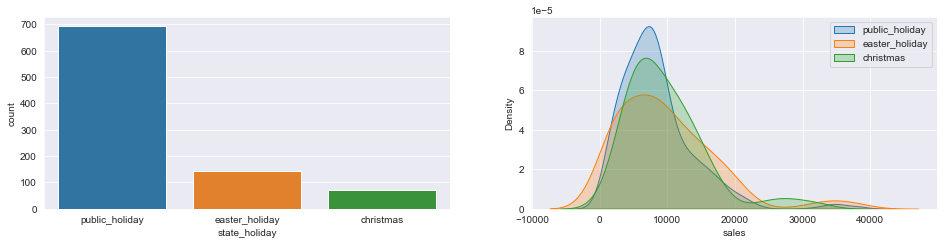

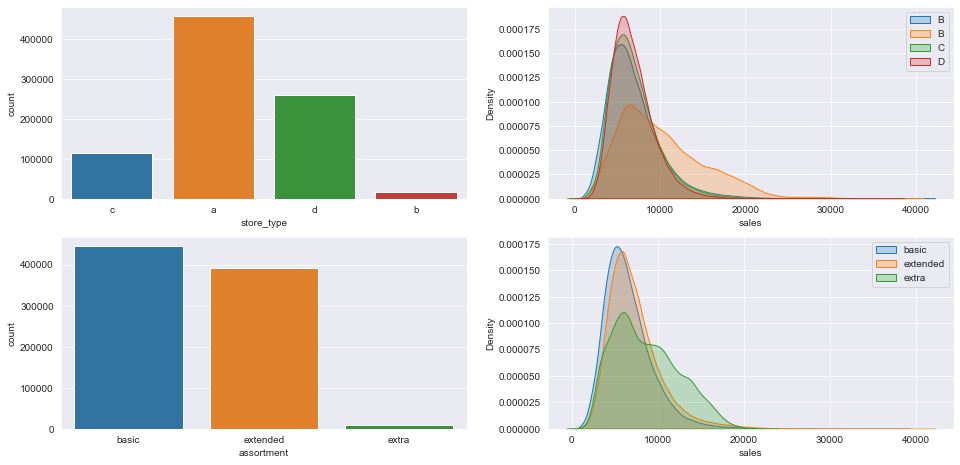

In [42]:
# state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize = (16, 12))
sns.set_style('darkgrid')

plt.subplot(3, 2, 1)
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True, label = 'public_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True, label = 'easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade = True, label = 'christmas')
plt.legend()
plt.plot()

# store_type
plt.figure(figsize = (16, 12))
sns.set_style('darkgrid')

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade = True, label = 'B')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade = True, label = 'B')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade = True, label = 'C')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade = True, label = 'D')
plt.legend()
plt.plot()
# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade = True, label = 'basic')
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade = True, label = 'extended')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade = True, label = 'extra')
plt.legend()
plt.plot()

In [43]:
basic = (df4[df4['assortment'] == 'basic']['sales']).mean()
extra = (df4[df4['assortment'] == 'extra']['sales']).mean()
extended  = (df4[df4['assortment'] == 'extended']['sales']).mean()

In [44]:
print(f'Average sales of the "basic" stores = {round(basic, 2)}')
print(f'Average sales of the "extra" stores = {round(extra, 2)}')
print(f'Average sales of the "extended" stores = {round(extended, 2)}')

Average sales of the "basic" stores = 6621.52
Average sales of the "extra" stores = 8642.5
Average sales of the "extended" stores = 7300.84


In [45]:
assortment_avg_sales = pd.DataFrame([round(basic, 2), round(extra, 2), round(extended, 2)],
                                    index = ['basic', 'extra', 'extended'])
assortment_avg_sales = assortment_avg_sales.T
assortment_avg_sales

,basic,extra,extended
0,"6,621.520000","8,642.500000","7,300.840000"


## Bivariate Analysis

### H1. Stores with a larger assortment should sell more.**

 **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
 
According with the data, stores with assortment type "extra" have a bigger average sales in comparison with "basic" type and "extended" type.
 

In [46]:
aux1_sum = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
aux1_mean = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
display(aux1_sum)
display(aux1_mean)

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


,assortment,sales
0,basic,"6,621.523057"
1,extended,"7,300.843547"
2,extra,"8,642.503594"


Text(0.5, 1.0, 'Average Sales by Assortment Type per Day')

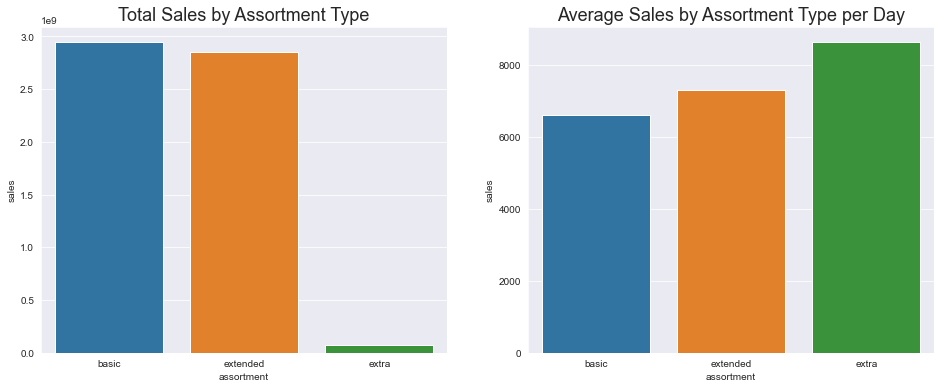

In [47]:
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x = 'assortment', y= 'sales', data = aux1_sum);
plt.title('Total Sales by Assortment Type', fontsize = 18)

plt.subplot(1, 2, 2)
sns.barplot(x = 'assortment', y= 'sales', data = aux1_mean);
plt.title('Average Sales by Assortment Type per Day', fontsize = 18)

In [48]:
aux2_week_mean = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2_week_sum = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

aux2_week_mean_pivot = aux2_week_mean.pivot(index = 'year_week', columns = 'assortment' , values = 'sales')
aux2_week_sum_pivot = aux2_week_sum.pivot(index = 'year_week', columns = 'assortment' , values = 'sales')

display(aux2_week_sum_pivot)
display(aux2_week_mean_pivot)

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


assortment,basic,extended,extra
year_week,,,
2013-00,"5,642.277194","6,094.001471","5,282.431373"
2013-01,"7,307.459961","7,553.623270","6,254.982143"
2013-02,"5,049.444788","5,283.317073","6,286.783333"
2013-03,"6,853.631919","6,983.376397","6,423.206349"
2013-04,"5,611.939028","5,944.287541","6,483.232143"
...,...,...,...
2015-26,"7,807.162647","8,788.728243","10,860.000000"
2015-27,"5,710.016830","6,624.242306","9,302.158730"
2015-28,"7,238.319933","8,299.772668","10,032.015873"


<AxesSubplot:xlabel='year_week'>

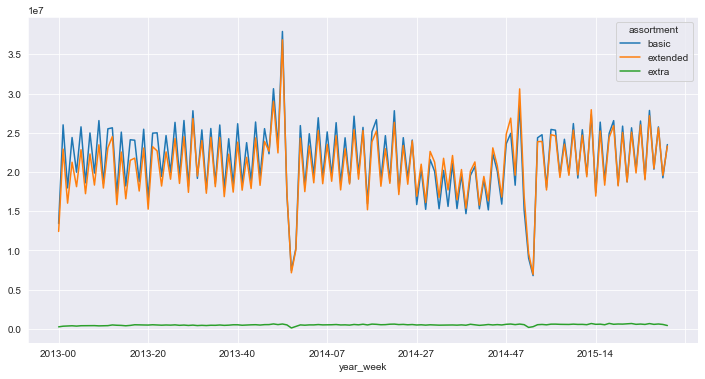

In [49]:
aux2_week_sum_pivot.plot(figsize = (12, 6))

Text(0.5, 1.0, 'Avg Sales by Assortment Type Store')

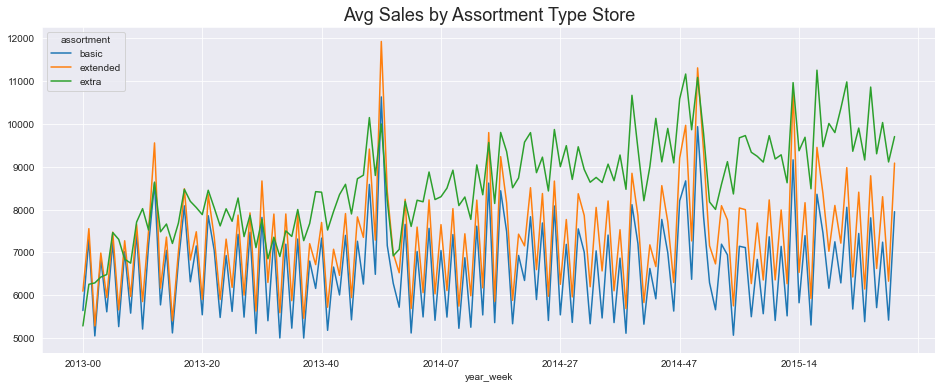

In [50]:
aux2_week_mean_pivot.plot(figsize = (16, 6))
plt.title('Avg Sales by Assortment Type Store', fontsize = 18)

### **H2. Stores with closer competitors should sell less.**

**CompetitionDistance** - distance in meters to the nearest competitor store

**False** - Stores with closer competitors tends to sell more, 
this is because stores with closest competitors are usually located in urban areas of larger cities, making sales better even with the proximity of competitors.

In [51]:
aux_sum = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux_mean = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

aux_sum.head()

,competition_distance,sales
0,20.000000,4579807
1,30.000000,17552666
2,40.000000,29261626
3,50.000000,60835848
4,60.000000,22088359


In [52]:
bins = np.arange(0, 50000, 1000)

aux_sum['competition_distance_binned'] = pd.cut(aux_sum['competition_distance'], bins = bins)
aux_mean['competition_distance_binned'] = pd.cut(aux_mean['competition_distance'], bins = bins)

display(aux_sum)
display(aux_mean)

,competition_distance,sales,competition_distance_binned
0,20.000000,4579807,"(0.0, 1000.0]"
1,30.000000,17552666,"(0.0, 1000.0]"
2,40.000000,29261626,"(0.0, 1000.0]"
3,50.000000,60835848,"(0.0, 1000.0]"
4,60.000000,22088359,"(0.0, 1000.0]"
...,...,...,...
650,"46,590.000000",3554993,"(46000.0, 47000.0]"
651,"48,330.000000",3798660,"(48000.0, 49000.0]"
652,"58,260.000000",5718883,NaN
653,"75,860.000000",6896821,NaN


,competition_distance,sales,competition_distance_binned
0,20.000000,"5,879.084724","(0.0, 1000.0]"
1,30.000000,"5,634.884751","(0.0, 1000.0]"
2,40.000000,"7,526.138374","(0.0, 1000.0]"
3,50.000000,"9,735.293327","(0.0, 1000.0]"
4,60.000000,"9,431.408625","(0.0, 1000.0]"
...,...,...,...
650,"46,590.000000","4,534.429847","(46000.0, 47000.0]"
651,"48,330.000000","4,845.229592","(48000.0, 49000.0]"
652,"58,260.000000","6,462.014689",NaN
653,"75,860.000000","7,775.446449",NaN


In [53]:
aux2_sum = aux_sum[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
aux2_mean = aux_mean[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

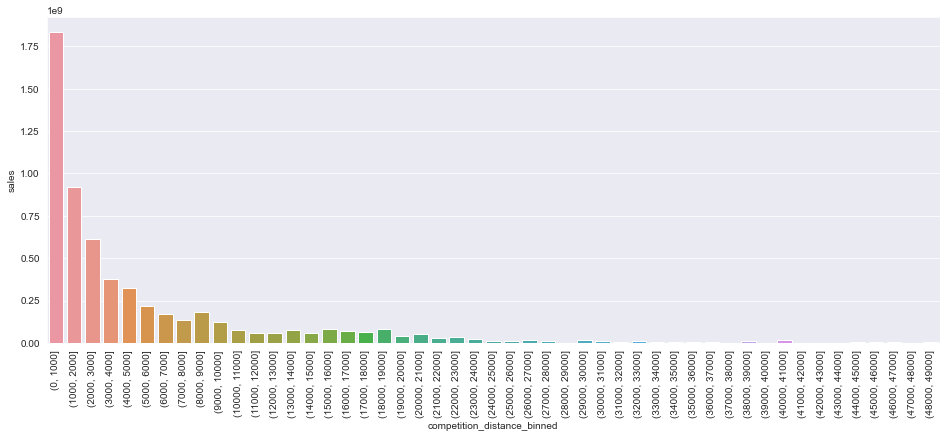

In [54]:
plt.figure(figsize = (16, 6))
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2_sum)
plt.xticks(rotation = 90);

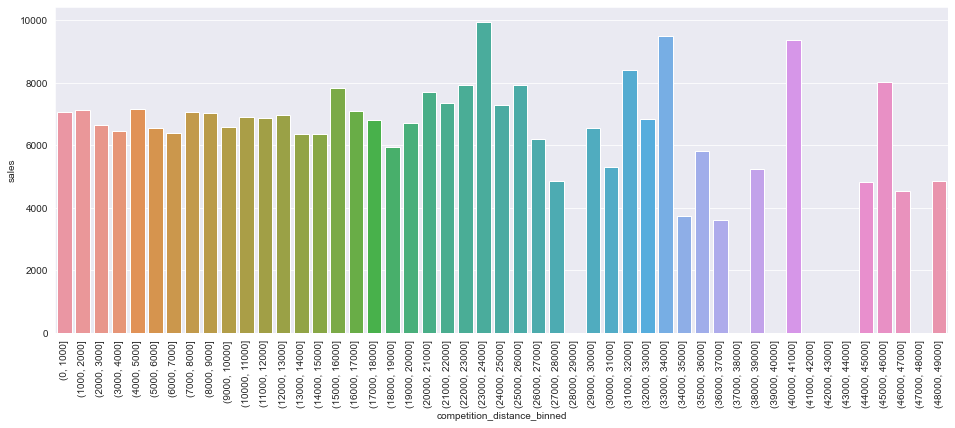

In [55]:
plt.figure(figsize = (16, 6))
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2_mean)
plt.xticks(rotation = 90);

In [56]:
aux_sum_closer = aux_sum[aux_sum['competition_distance'] < 50000]

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

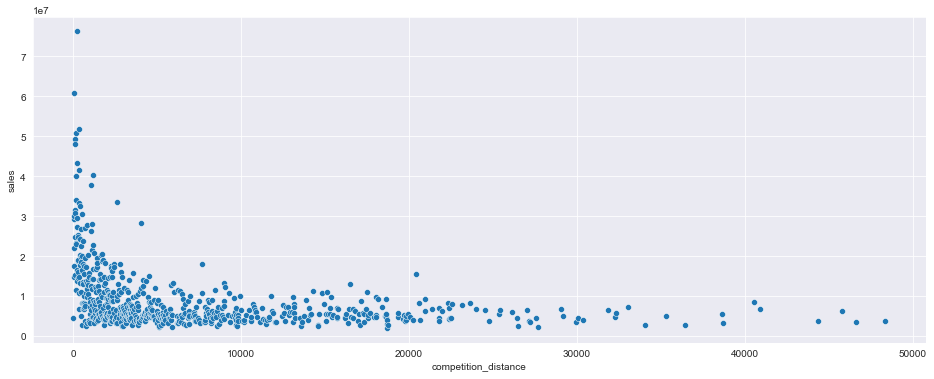

In [57]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_sum_closer)

In [58]:
aux_mean_closer = aux_mean[aux_mean['competition_distance'] < 50000]

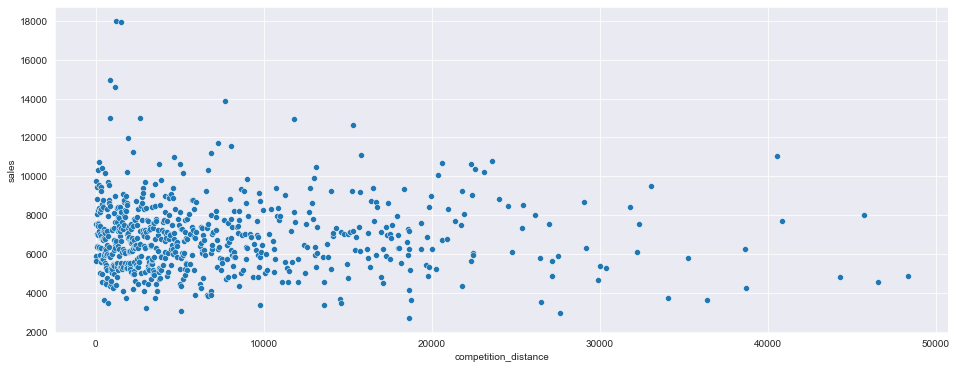

In [59]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_mean_closer);

In [60]:
aux_sum.head().T

,0,1,2,3,4
competition_distance,20.0,30.0,40.0,50.0,60.0
sales,4579807,17552666,29261626,60835848,22088359
competition_distance_binned,"(0, 1000]","(0, 1000]","(0, 1000]","(0, 1000]","(0, 1000]"


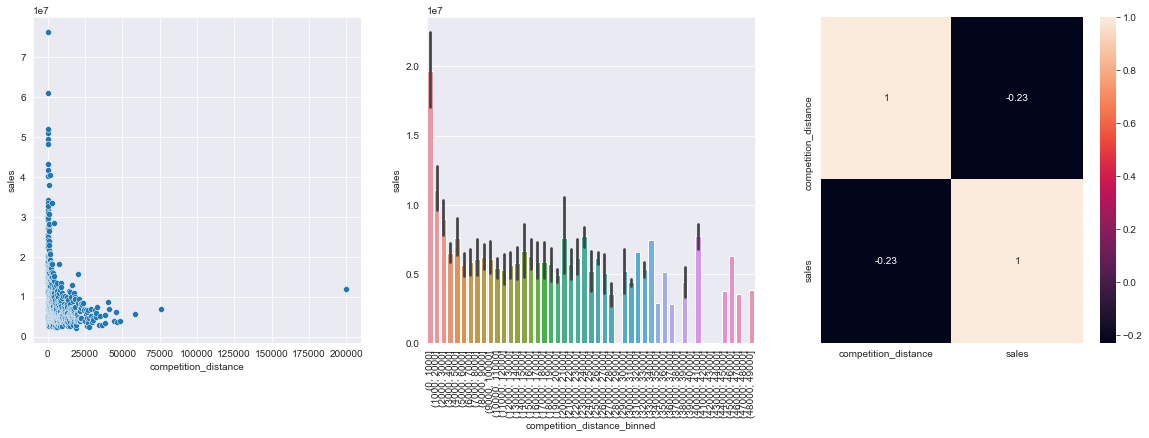

In [61]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_sum);

plt.subplot(1, 3, 2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux_sum);
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

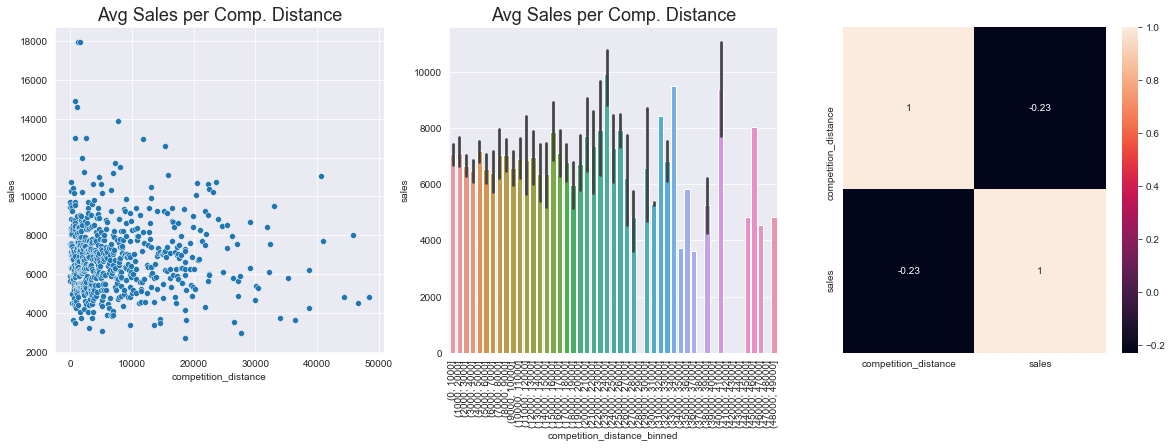

In [62]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_mean_closer);
plt.title('Avg Sales per Comp. Distance', fontsize = 18)

plt.subplot(1, 3, 2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux_mean_closer);
plt.title('Avg Sales per Comp. Distance', fontsize = 18)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

### **H3. Stores with longer open competitors are expected to sell more.**

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**True** - Stores with longer time open competitors have better average sales then stores with less time competitor's open.

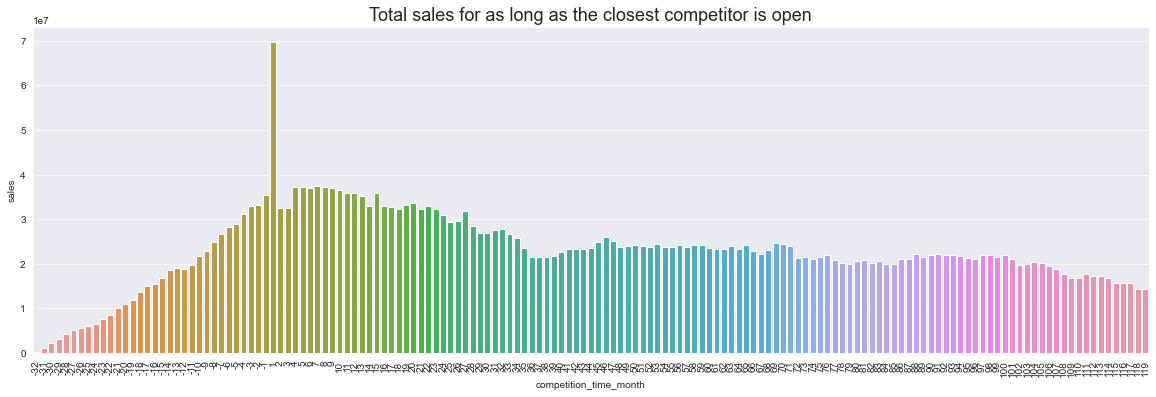

In [63]:
plt.figure(figsize = (20, 6))

aux_mean = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux_mean_2 = aux_mean[(aux_mean['competition_time_month'] < 120) & (aux_mean['competition_time_month'] != 0)]
aux_sum = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux_sum_2 = aux_sum[(aux_sum['competition_time_month'] < 120) & (aux_sum['competition_time_month'] != 0)]


sns.barplot(x = 'competition_time_month', y = 'sales', data = aux_sum_2);
plt.title('Total sales for as long as the closest competitor is open', fontsize = 18)
plt.xticks(rotation = 90);

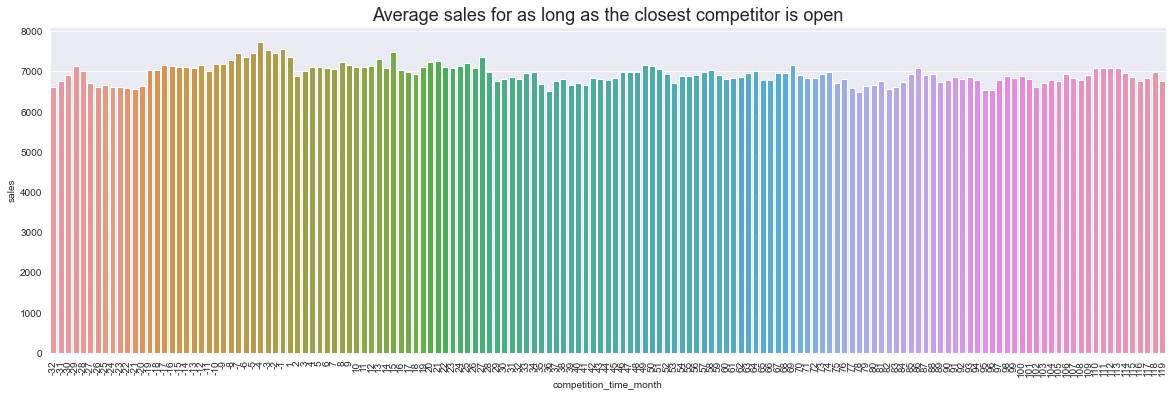

In [64]:
plt.figure(figsize = (20, 6))
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux_mean_2);
plt.title('Average sales for as long as the closest competitor is open', fontsize = 18)
plt.xticks(rotation = 90);

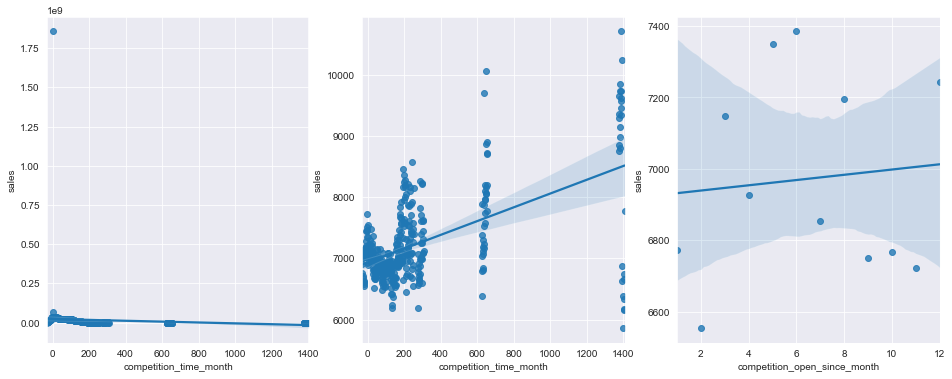

In [65]:
aux2_mean = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').mean().reset_index()
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux_sum);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales' ,data = aux_mean);

plt.subplot(1, 3, 3)
sns.regplot(x = 'competition_open_since_month', y = 'sales' ,data = aux2_mean);

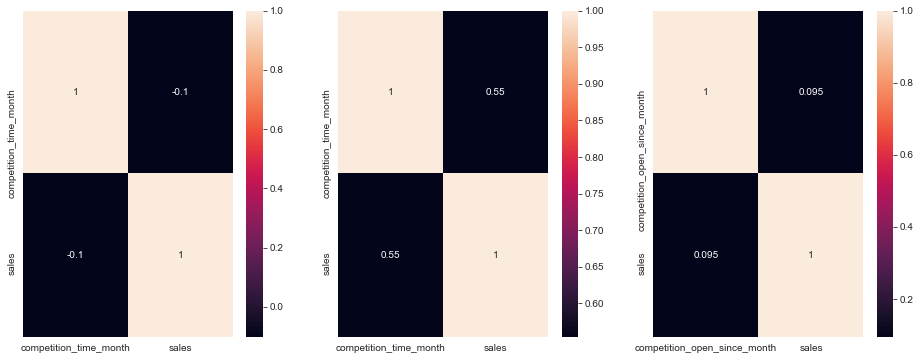

In [66]:
aux2_mean = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').mean().reset_index()

plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

plt.subplot(1, 3, 2)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);

plt.subplot(1, 3, 3)
sns.heatmap(aux2_mean.corr(method = 'pearson'), annot = True);

### **H4.** Stores with active promotions for a longer time should sell more.

**FALSE** - Apparently stores with promotions for more time have no better or worst sales than stores with less promotions time.

In [67]:
aux_sum = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

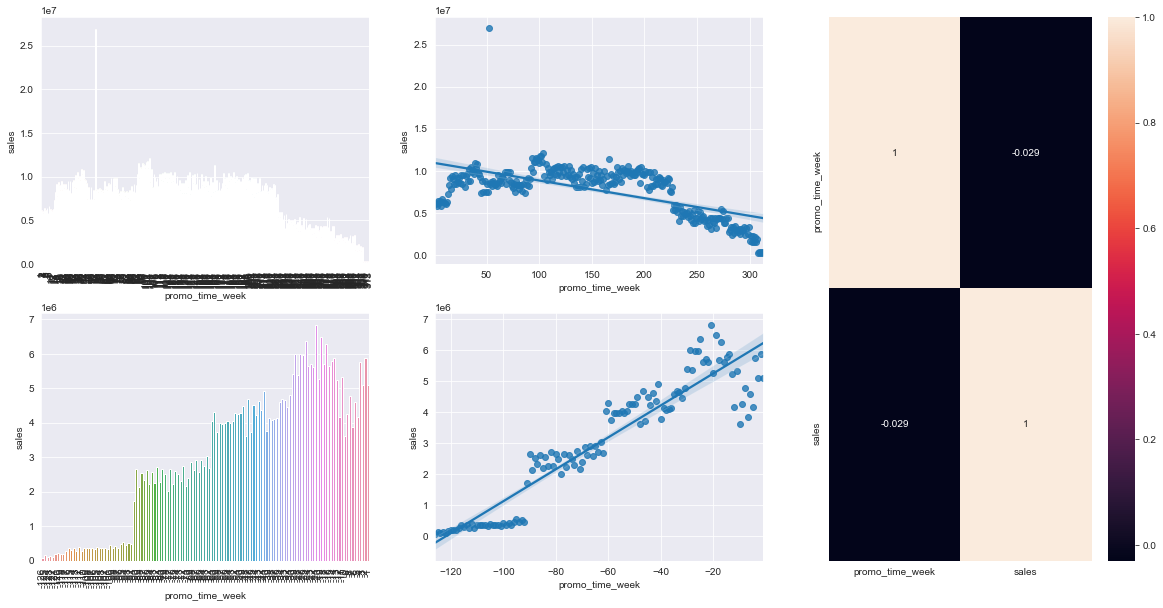

In [68]:
plt.figure(figsize = (20, 10))

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux1 = aux_sum[aux_sum['promo_time_week'] > 0]  #extended promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux1);

plt.subplot(grid[1, 0])
aux2 = aux_sum[aux_sum['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[:, 2])
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

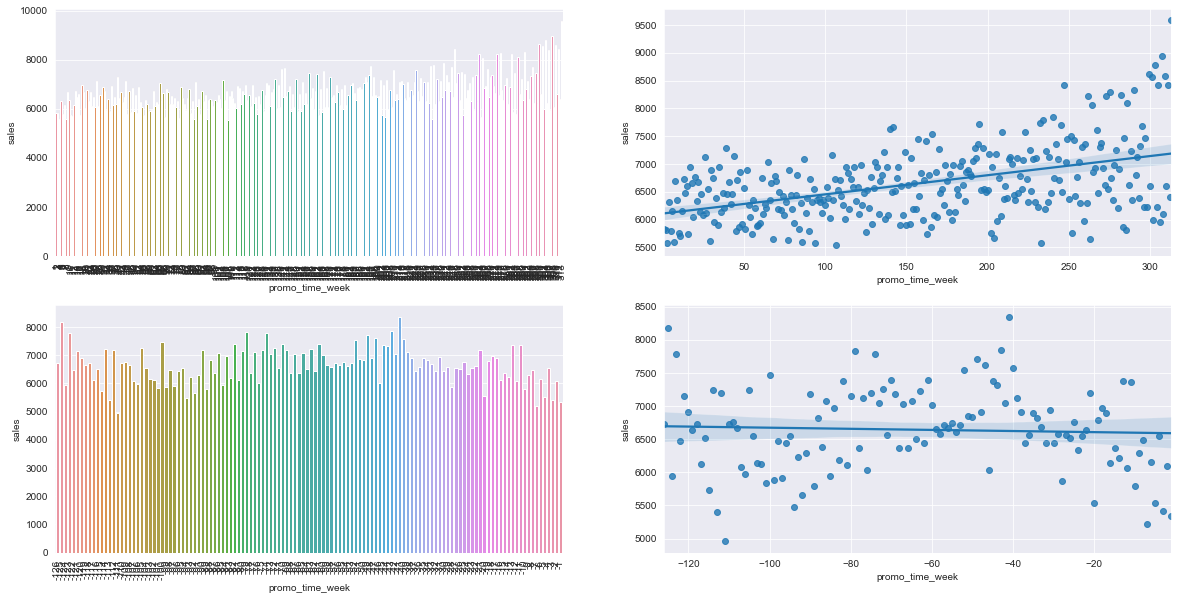

In [69]:
aux_mean = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

plt.figure(figsize = (20, 10))

plt.subplot(2, 2, 1)
aux1 = aux_mean[aux_mean['promo_time_week'] > 0]  #extended promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
aux2 = aux_mean[aux_mean['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 4)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

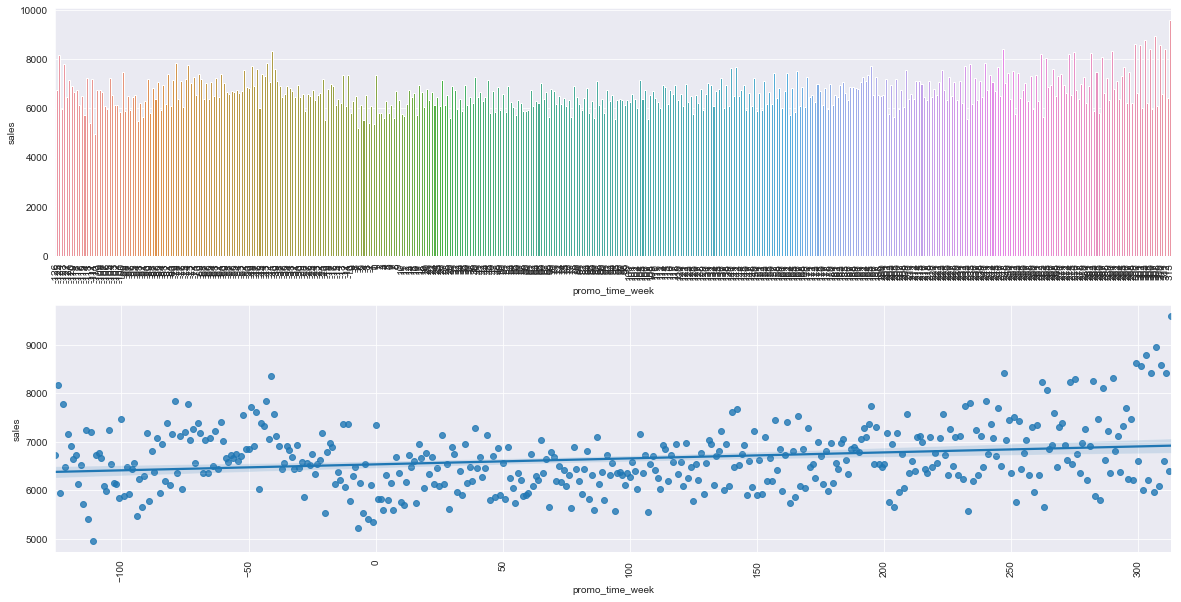

In [70]:
plt.figure(figsize = (20, 10))

plt.subplot(2, 1, 1)
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux_mean);
plt.xticks(rotation = 90);

plt.subplot(2, 1, 2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux_mean);
plt.xticks(rotation = 90);

### <s>**H5.** Stores with more promotion days should sell more.</s>

### **H6.** Stores with more consecutive promotions should sell more.

**FALSE** - Stores with more consecutive promotions tends to sell less.

In [71]:
display(df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index())
display(df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index())

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


,promo,promo2,sales
0,0,0,"6,328.187633"
1,0,1,"5,529.566684"
2,1,0,"8,618.452062"
3,1,1,"7,836.672987"


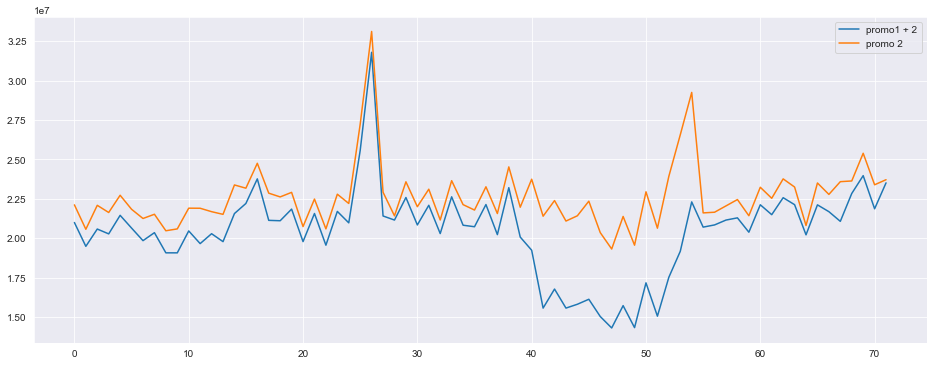

In [72]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize = (16, 6))
aux1_2.plot(figsize = (16, 6), ax = ax)

plt.legend(labels = ['promo1 + 2', 'promo 2'])

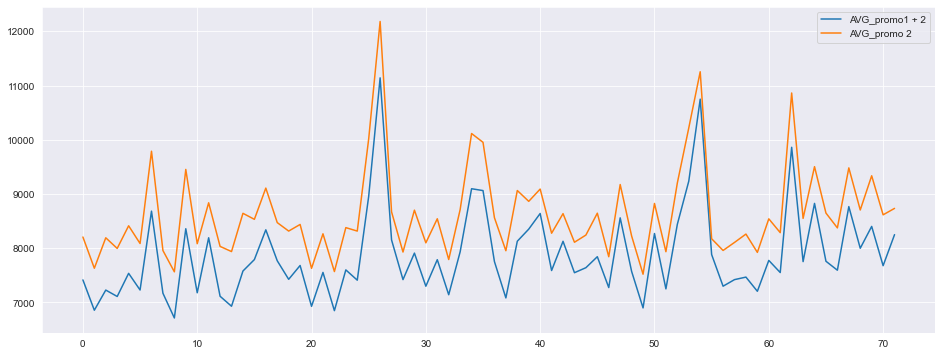

In [73]:
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux2.plot(figsize = (16, 6))
aux2_2.plot(figsize = (16, 6), ax = ax)

plt.legend(labels = ['AVG_promo1 + 2', 'AVG_promo 2'])

### **H7.** Stores open during the Christmas holiday should sell more.

   **True** - The average sales during christmas and easter holiday are much better than in a regular day. 
   Something like 42% better.

In [74]:
aux_sum = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux_mean = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
aux = df4[df4['state_holiday'] != 'regular_day']
aux_no_regular_day = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

In [75]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [76]:
display(aux_sum.head())
display(aux_mean.head())

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305
3,regular_day,5865164768


,state_holiday,sales
0,christmas,"9,743.746479"
1,easter_holiday,"9,887.889655"
2,public_holiday,"8,487.471182"
3,regular_day,"6,953.960229"


In [77]:
(aux_mean['sales'][1] * 100) / aux_mean['sales'][3]

142.19077086433794

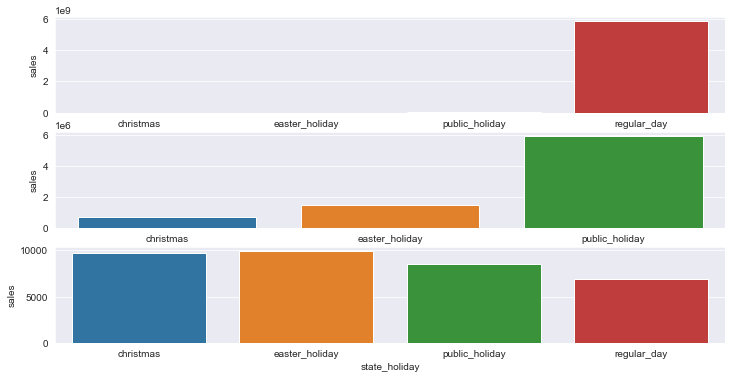

In [78]:
plt.figure(figsize = (12, 6))

plt.subplot(3, 1, 1)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux_sum);

plt.subplot(3, 1, 2)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux_no_regular_day);

plt.subplot(3, 1, 3)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux_mean);

In [79]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [80]:
aux2_sum = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
aux2_mean = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()

display(aux2_sum)
display(aux2_mean)

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


,year,state_holiday,sales
0,2013,christmas,"9,199.500000"
1,2013,easter_holiday,"9,680.787234"
2,2013,public_holiday,"7,863.632184"
3,2013,regular_day,"6,813.310910"
4,2014,christmas,"10,303.542857"
5,2014,easter_holiday,"9,456.183673"
6,2014,public_holiday,"8,685.900000"
7,2014,regular_day,"7,024.089786"
8,2015,easter_holiday,"10,518.244898"
9,2015,public_holiday,"9,084.357513"


Text(0.5, 1.0, 'Average Sales per State Holiday')

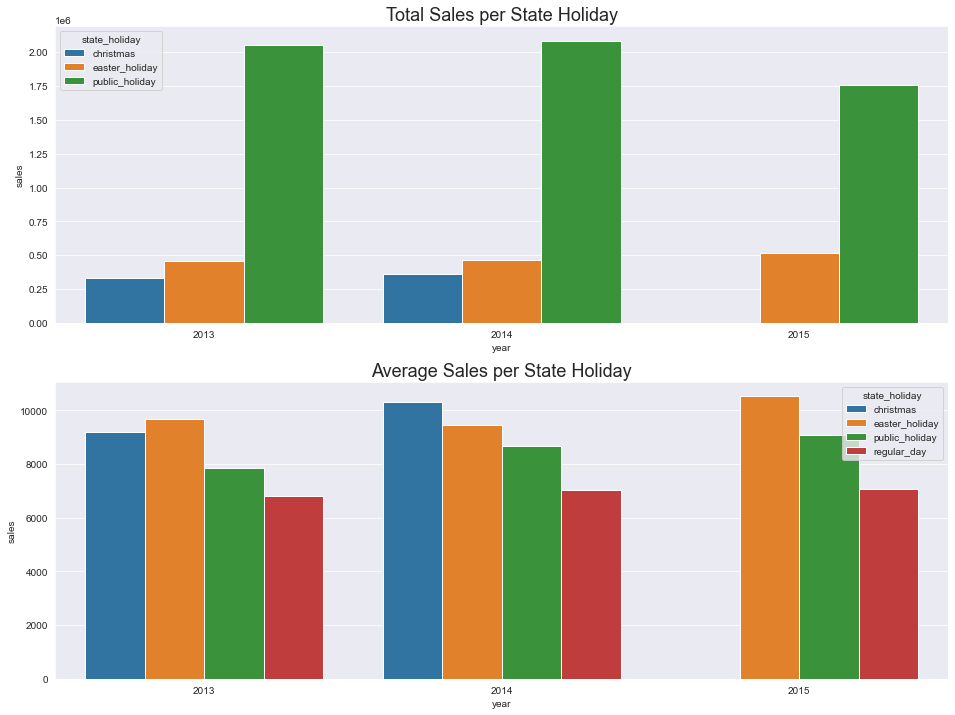

In [81]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2_sum);
plt.title('Total Sales per State Holiday', fontsize = 18)

plt.subplot(2, 1, 2)
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2_mean);
plt.title('Average Sales per State Holiday', fontsize = 18)

### **H8.** Stores should sell more over the years.

**TRUE** - The average sales is better over the years.

In [82]:
aux_sum = df4[['year', 'sales']].groupby('year').sum().reset_index()
aux_mean = df4[['year', 'sales']].groupby('year').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

display(aux_sum)
display(aux_mean)

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


,year,avg_sales
0,2013,"6,814.780000"
1,2014,"7,026.130000"
2,2015,"7,088.240000"


Text(0.5, 1.0, 'Average Sales X Year')

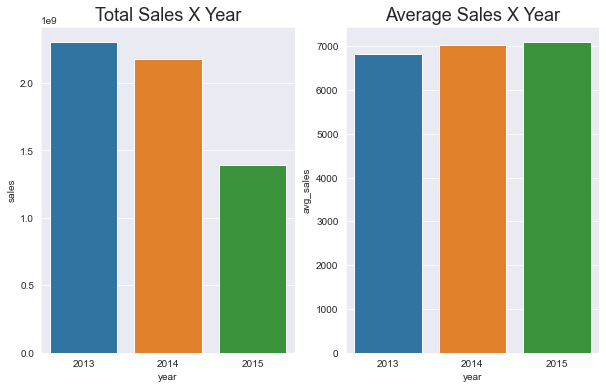

In [83]:
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x = 'year', y = 'sales', data = aux_sum);
plt.title('Total Sales X Year', fontsize = 18)

plt.subplot(1, 2, 2)
sns.barplot(x = 'year', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X Year', fontsize = 18)

In [84]:
df4['year'].value_counts()

2013    337924
2014    310385
2015    196029
Name: year, dtype: int64

In [85]:
df4.date.max()

Timestamp('2015-07-31 00:00:00')

Text(0.5, 1.0, 'Average Sales Corr Map')

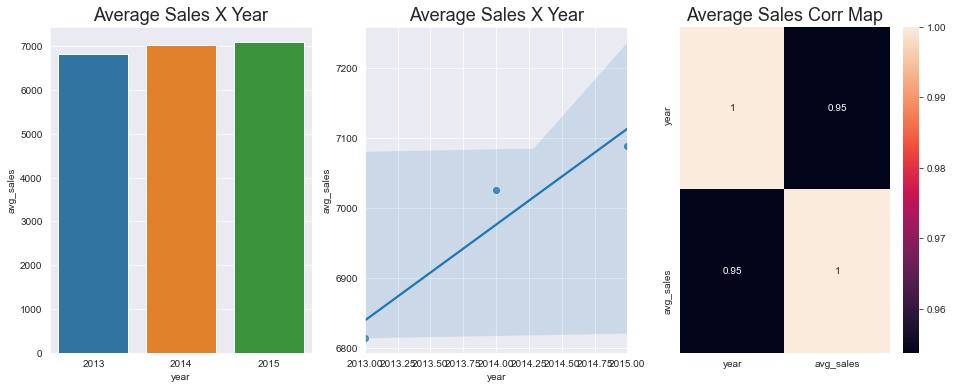

In [86]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X Year', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X Year', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);
plt.title('Average Sales Corr Map', fontsize = 18)

### **H9.** Stores should sell more in the second half of the year.

**INCONCLUSIVE** - according the data there is a balance during the months, with some elevation of average sales between March and July, but not much. Only December has a major average sales increase.

In [87]:
aux_sum = df4[['month', 'sales']].groupby('month').sum().reset_index()
aux_mean = df4[['month', 'sales']].groupby('month').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

#display(aux_sum)
#display(aux_mean)

Text(0.5, 1.0, 'Total Sales Corr Map')

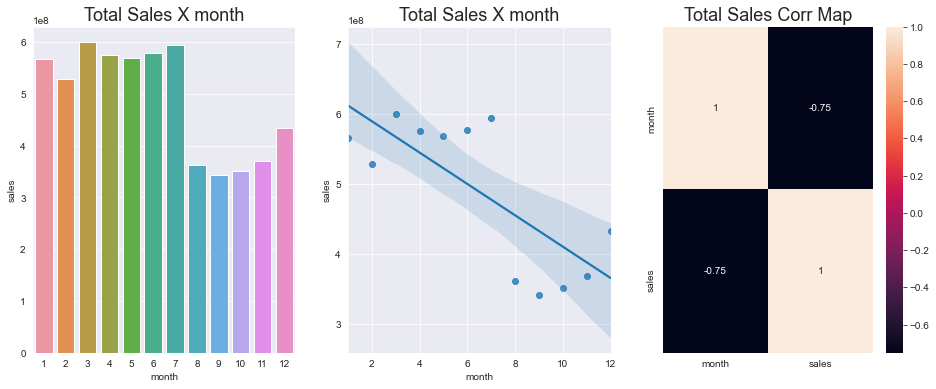

In [88]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux_sum);
plt.title('Total Sales X month', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux_sum);
plt.title('Total Sales X month', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);
plt.title('Total Sales Corr Map', fontsize = 18)

Text(0.5, 1.0, 'Average Sales Corr Map')

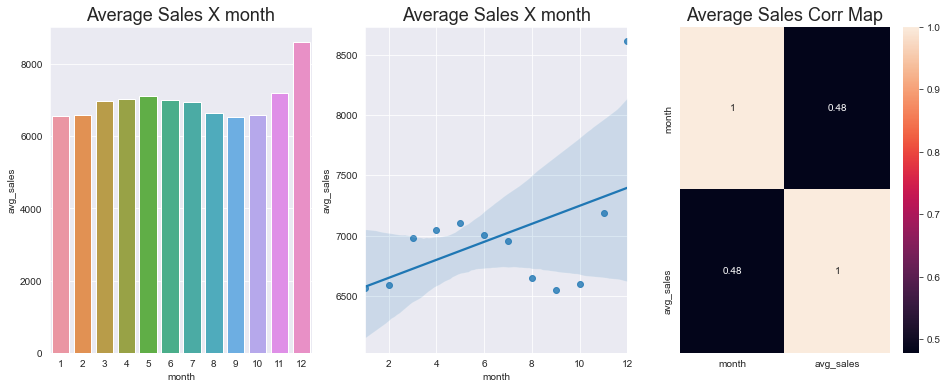

In [89]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X month', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X month', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);
plt.title('Average Sales Corr Map', fontsize = 18)

### **H10.** Stores should sell more after the 10th of each month.

**INCONCLUSIVE**

In [90]:
aux_sum = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux_mean = df4[['day', 'sales']].groupby('day').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

Text(0.5, 1.0, 'Total Sales Corr Map')

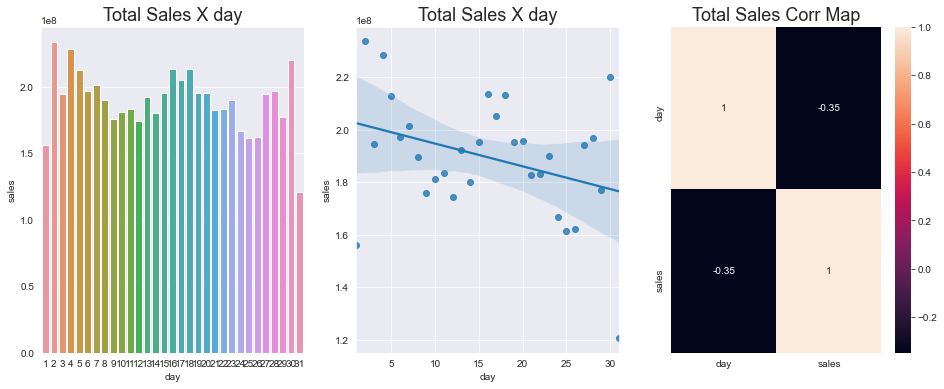

In [91]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y = 'sales', data = aux_sum);
plt.title('Total Sales X day', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'sales', data = aux_sum);
plt.title('Total Sales X day', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);
plt.title('Total Sales Corr Map', fontsize = 18)

Text(0.5, 1.0, 'Average Sales Corr Map')

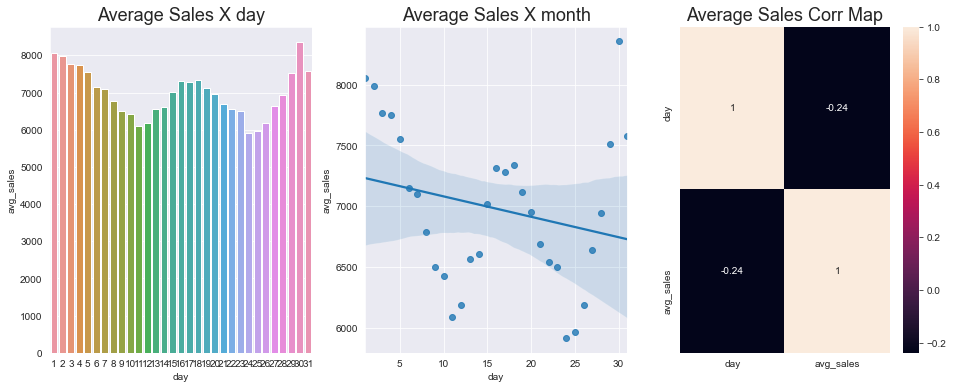

In [92]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X day', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X month', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);
plt.title('Average Sales Corr Map', fontsize = 18)

In [93]:
aux_sum['before_after_10th_day'] = aux_sum['day'].apply(lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day')
aux_mean['before_after_10th_day'] = aux_mean['day'].apply(lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day')

In [94]:
aux_sum_2 = aux_sum[['before_after_10th_day', 'sales']].groupby('before_after_10th_day').sum().reset_index()

<AxesSubplot:xlabel='before_after_10th_day', ylabel='sales'>

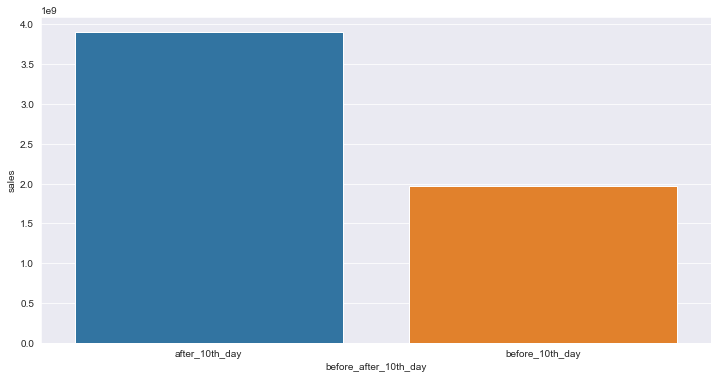

In [95]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'before_after_10th_day', y = 'sales', data = aux_sum_2)

In [96]:
display(aux_sum_2)
print(3902775310 / 20)
print(1970405313 / 10)

,before_after_10th_day,sales
0,after_10th_day,3902775310
1,before_10th_day,1970405313


195138765.5
197040531.3


<AxesSubplot:>

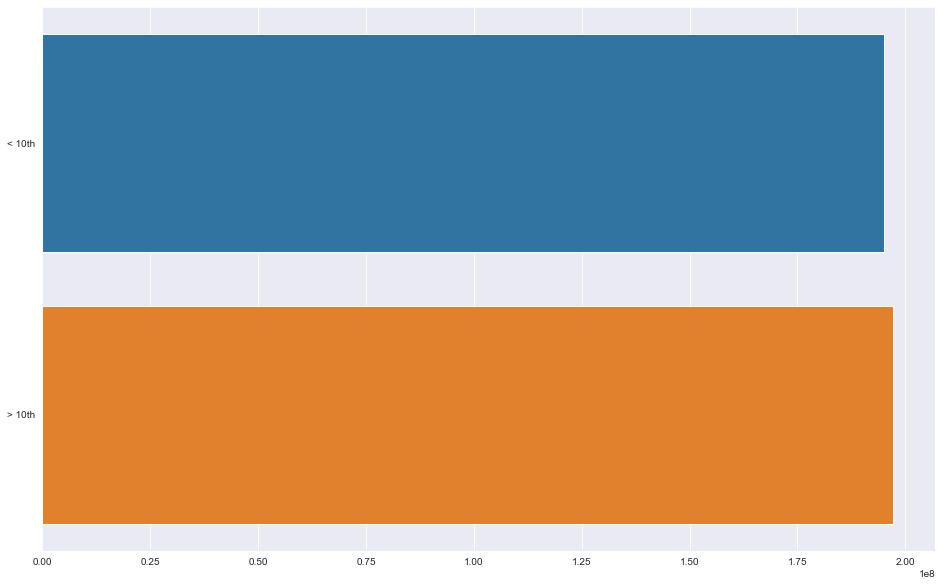

In [97]:
x = [195138765.5, 197040531.3]
y = ['< 10th', '> 10th']

sns.barplot(x = x, y = y)

### **H11.** Stores should sell less on weekends.

**FALSE** - Stores sell less on weekends.

In [98]:
aux_sum = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
aux_mean = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

Text(0.5, 1.0, 'Total Sales Corr Map')

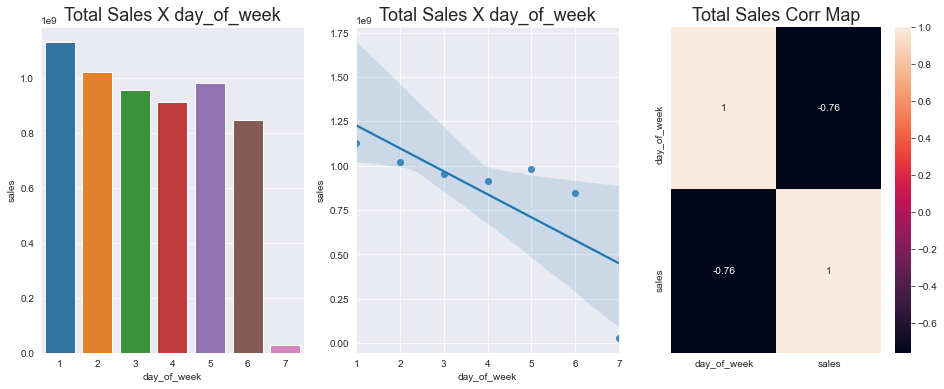

In [99]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux_sum);
plt.title('Total Sales X day_of_week', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux_sum);
plt.title('Total Sales X day_of_week', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);
plt.title('Total Sales Corr Map', fontsize = 18)

### **H12.** Stores should sell less on school holidays.

**INCONCLUSIVE** - The total sales amount in a not school holiday is bigger, but stores who are open in a school holiday tends to have a average sell better.

In [100]:
aux_SH_sum = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux_SH_mean = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

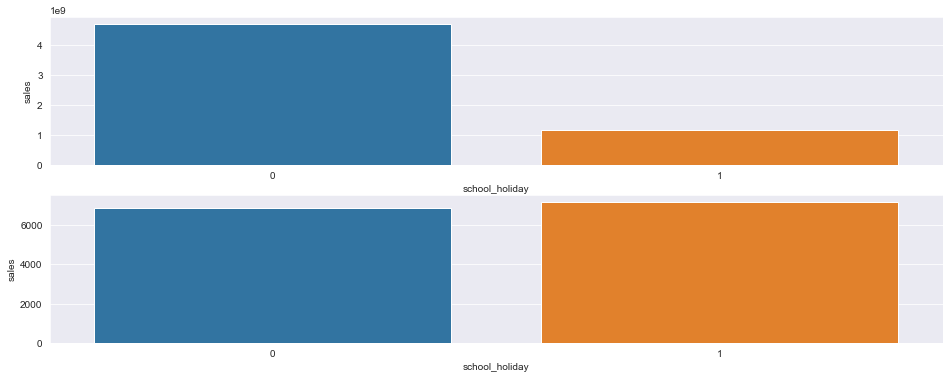

In [101]:
plt.figure(figsize = (16, 6))

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux_SH_sum);

plt.subplot(2, 1, 2)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux_SH_mean);

In [102]:
aux_SH_sum_2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
aux_SH_mean_2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()

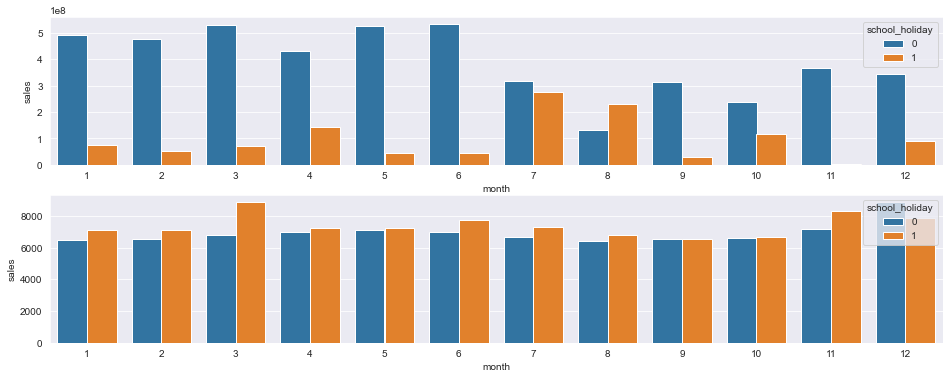

In [103]:
plt.figure(figsize = (16, 6))

plt.subplot(2, 1, 1)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux_SH_sum_2);

plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux_SH_mean_2);

## Multivariate Analysis

### Numerical Attributes

In [104]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,"1,270.000000",9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.000000,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,"14,130.000000",12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.000000,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,"29,910.000000",4,2015,0,31,2015,0


<AxesSubplot:>

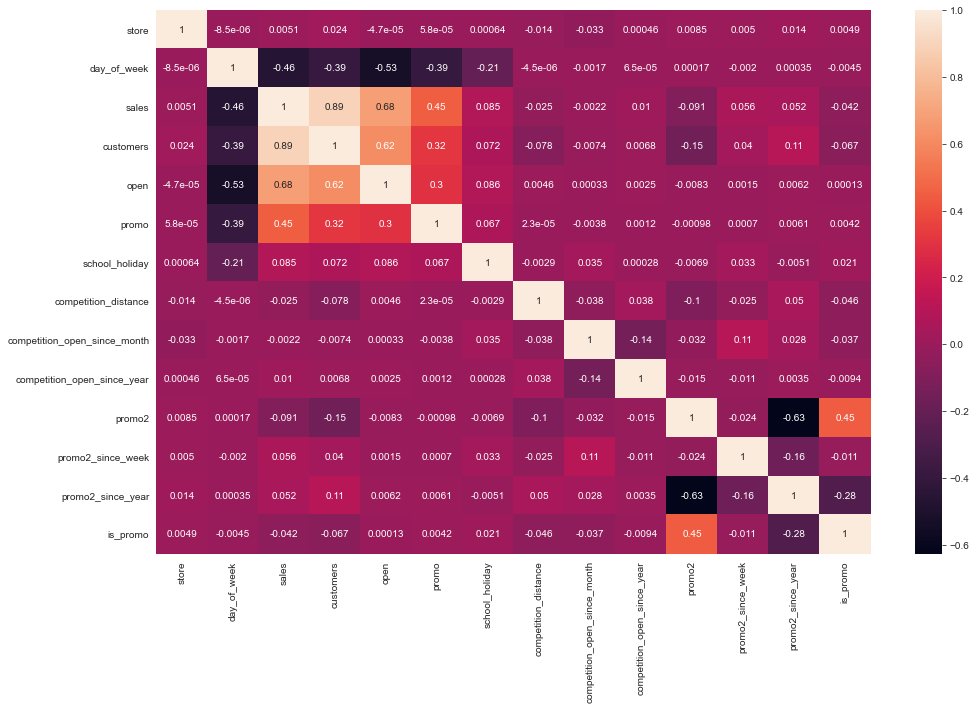

In [105]:
correlation = num_attributes.corr(method = 'pearson')

plt.figure(figsize = (16, 10))
sns.heatmap(correlation, annot = True)

### Categorical Attributes

In [106]:
aux = df4.select_dtypes(include = 'object')
aux.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


Crammer's V calc:

In [107]:
cm = pd.crosstab(aux['state_holiday'], aux['store_type']).values
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [108]:
aux[(aux['state_holiday'] == 'christmas') & (aux['store_type'] == 'a')]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [109]:
a1 = cramer_v(aux['state_holiday'], aux['state_holiday'])
a2 = cramer_v(aux['state_holiday'], aux['store_type'])
a3 = cramer_v(aux['state_holiday'], aux['assortment'])

a4 = cramer_v(aux['store_type'], aux['state_holiday'])
a5 = cramer_v(aux['store_type'], aux['store_type'])
a6 = cramer_v(aux['store_type'], aux['assortment'])

a7 = cramer_v(aux['assortment'], aux['state_holiday'])
a8 = cramer_v(aux['assortment'], aux['store_type'])
a9 = cramer_v(aux['assortment'], aux['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

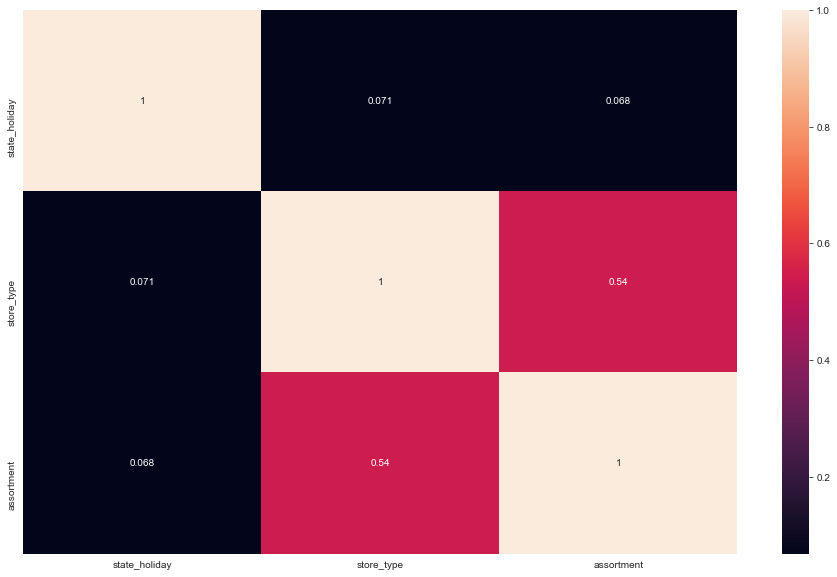

In [110]:
sns.heatmap(d, annot = True)

# Data Modeling.

In [268]:
df5 = df4.copy()

## Data Preparation

### Normalization

    - Xnew = (Xi - VARmean) / VARStd

<Figure size 1152x432 with 0 Axes>

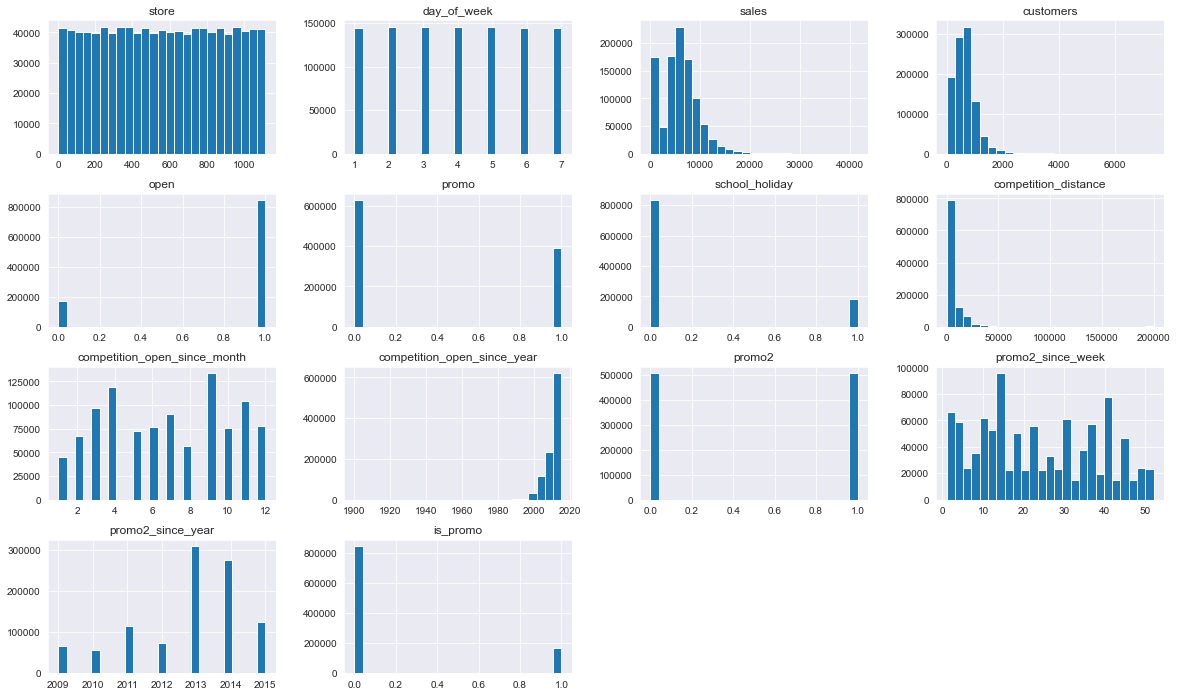

In [112]:
plt.figure(figsize = (16, 6))
num_attributes.hist(figsize = (20,12), bins = 25);

There is no variables in the Dataframe with a good normal distribution to apply the normalization.

### Rescaling

    - Xnew = (Xi - VARmean) / (Xmax - Xmin)
    
   **Robust Scaler** - Eliminates the outliers issue
   
    - Xnew = (Xi - Q1(x)) / (Q3(x) - Q1(x))

In [113]:
num_var = df5.select_dtypes(include = ['int64', 'float64'])

In [114]:
num_var.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,"1,270.000000",9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.000000,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,"14,130.000000",12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.000000,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,"29,910.000000",4,2015,0,31,2015,0,2015,7,31,31,4,0


<AxesSubplot:xlabel='competition_distance'>

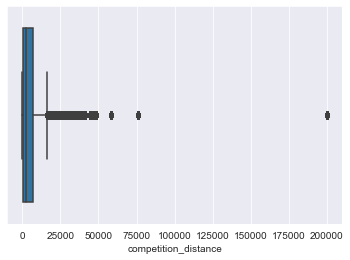

In [115]:
# competition_distance
# Check for outliers
plt.figure(figsize = (6, 4))
sns.boxplot(num_var['competition_distance'])

In [116]:
rs = RobustScaler()

num_var['competition_distance'] = rs.fit_transform(num_var[['competition_distance']].values)

In [276]:
'''
rs = RobustScaler()
mms = MinMaxScaler()

# Competition Distance
df5['competition_distance'] = rs.fit_transform(num_var[['competition_distance']].values)
pickle.dump(rs, open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\competition_distance_scaler.pkl', 'wb'))

# Competition Time Month
df5['competition_time_month'] = rs.fit_transform(num_var[['competition_time_month']].values)
pickle.dump(rs, open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\competition_time_month_scaler.pkl', 'wb'))

# Promo Time Week
df5['promo_time_week'] = mms.fit_transform(num_var[['promo_time_week']].values)
pickle.dump(rs, open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\promo_time_week_scaler.pkl', 'wb'))

# Year
df5['year'] = mms.fit_transform(num_var[['year']].values)
pickle.dump(mms, open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\year_scaler.pkl', 'wb'))
'''

In [269]:
'''
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['st_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
'''

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

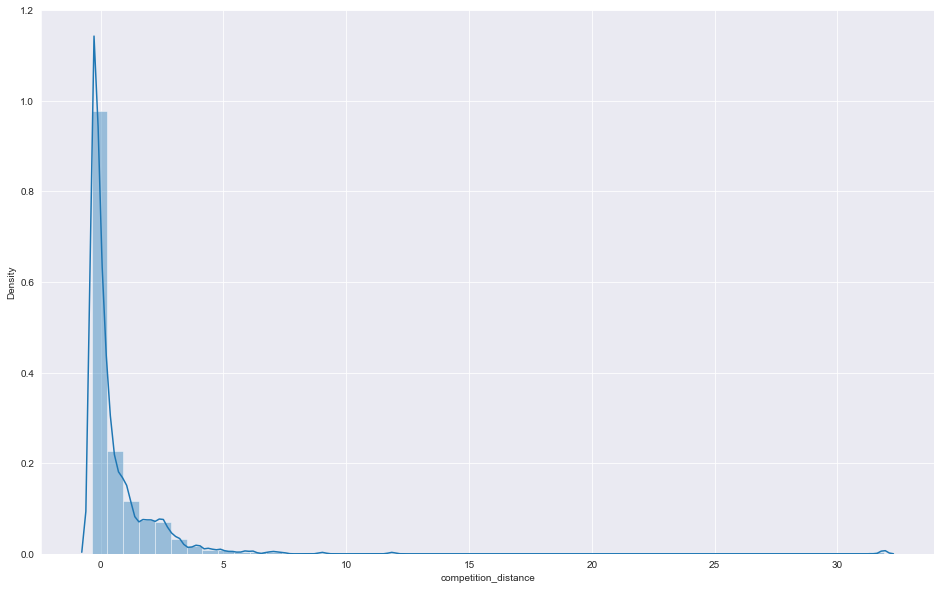

In [117]:
sns.distplot(num_var['competition_distance'])

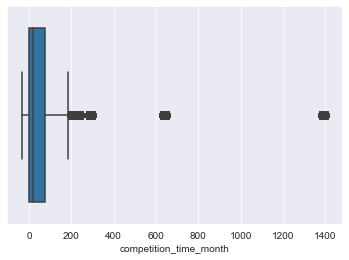

In [118]:
# competition_time_month
plt.figure(figsize = (6, 4))
sns.boxplot(num_var['competition_time_month']);

In [119]:
num_var['competition_time_month'] = rs.fit_transform(num_var[['competition_time_month']].values)

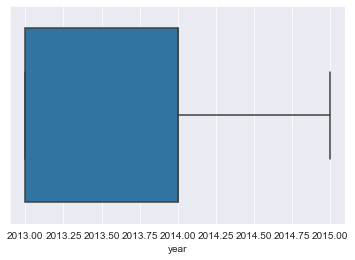

In [120]:
# year
plt.figure(figsize = (6, 4))
sns.boxplot(num_var['year']);

In [121]:
mms = MinMaxScaler()

num_var['year'] = mms.fit_transform(num_var[['year']].values)

<AxesSubplot:xlabel='promo_time_week'>

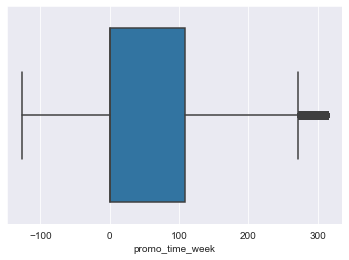

In [122]:
# promo_time_week
plt.figure(figsize = (6, 4))
sns.boxplot(num_var['promo_time_week'])

In [123]:
mms = MinMaxScaler()

num_var['promo_time_week'] = mms.fit_transform(num_var[['promo_time_week']].values)

In [124]:
display(df5['promo_time_week'])
display(num_var['promo_time_week'])

0            0
1          279
2          226
3            0
4            0
          ... 
1016776      0
1016827      0
1016863      6
1017042      0
1017190      0
Name: promo_time_week, Length: 844338, dtype: int64

0         0.287016
1         0.922551
2         0.801822
3         0.287016
4         0.287016
            ...   
1016776   0.287016
1016827   0.287016
1016863   0.300683
1017042   0.287016
1017190   0.287016
Name: promo_time_week, Length: 844338, dtype: float64

### Encoding

    - One Hot Encoding
    - Label Encoding
    - Ordinal Encoding
    - Target Encoding
    - Frequency Encoding
    - Embeding Encoding
    
http://contrib.scikit-learn.org/category_encoders/

In [125]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['st_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])  

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### Response Variable Transformation

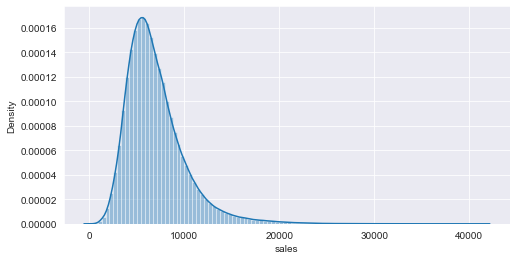

In [126]:
plt.figure(figsize = (8, 4))
ax = sns.distplot(df5.sales, bins  = 100)

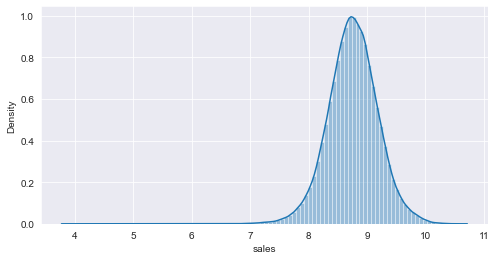

In [127]:
# log transformation

df5.sales = np.log1p(df5.sales)
plt.figure(figsize = (8, 4))
ax = sns.distplot(df5.sales, bins  = 100)

### Nature Transformation

- "Cyclical Variables".

In [128]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month
df5['month_sin'] = df5.month.apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5.month.apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

In [129]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,st_holiday_public_holiday,st_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,"1,270.000000",9,...,0,1,-0.974928,-0.222521,-0.500000,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,570.000000,11,...,0,1,-0.974928,-0.222521,-0.500000,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,"14,130.000000",12,...,0,1,-0.974928,-0.222521,-0.500000,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,620.000000,9,...,0,1,-0.974928,-0.222521,-0.500000,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,"29,910.000000",4,...,0,1,-0.974928,-0.222521,-0.500000,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# Feature Selection

In [130]:
df6 = df5.copy()

## Split DataFrame Into Training and Test

In [131]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [132]:
df6[['store', 'date']].groupby('store').min().reset_index().head()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02


In [133]:
df6[['store', 'date']].groupby('store').max().reset_index().head()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31


In [134]:
# Axcluding 6 weeks from the dataset, to from the train dataset.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)

Timestamp('2015-06-19 00:00:00')

In [135]:
# Training DataSets
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test DataSets
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Min Date: {X_train["date"].max()}')

print(f'\nTraining Min Date: {X_test["date"].min()}')
print(f'Training Min Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Min Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Min Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [136]:
# Training and Test DataSets for Boruta
#x_train_n = x_train.drop(['date', 'sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = -1)

# Define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

In [137]:
#boruta

### Best Features from Boruta

In [138]:
#cols_selected = boruta.support_.tolist()

# Best Features
#x_train_fs = x_train.drop(['date', 'sales'], axis = 1)

#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# Coluns not selected - Boruta
#not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## Manual Feature Selection

In [139]:
cols_selected_boruta = ['store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'week_of_year_sin']

# Columns to add
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [140]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# Machine Learning Modeling

In [141]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series data preparation.
x_training = X_train[cols_selected_boruta_full]

In [142]:
print(f'{len(X_test)} - {len(X_train)} - {len(y_test)} - {len(y_train)}')

41396 - 802942 - 41396 - 802942


## Average Model

In [143]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) # expm1 -> exponetial -> return log convertion.

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,"1,354.800353",0.455051,"1,835.135542"


## Linear Regression Model

In [144]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,"1,867.089774",0.292694,"2,671.049215"


### Linear Regression Model - Cross Validation.

In [145]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', model = LinearRegression())
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## Linear Regression Regularized Model - Lasso

In [146]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,"1,890.285926",0.294716,"2,720.254330"


### Linear Regression Regularized Model - Lasso - Cross Validation

In [147]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2113.25 +/- 343.98,0.29 +/- 0.01,3047.69 +/- 509.99


## Random Forest Regressor

In [148]:
'''# Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result'''

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.377126,0.099640,"1,007.787816"


### Random Forest Regressor - Cross Validation

In [149]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
#rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.85 +/- 217.96,0.12 +/- 0.02,1256.56 +/- 318.0


## XGboost Regressor

In [150]:
'''# Model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytree = 0.9).fit(x_train, y_train)
# There are also an XGBClassification algorithm.

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result'''

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,"6,683.408009",0.949433,"7,330.688281"


### XGboost Regressor - Cross Validation

In [151]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGboost Regressor', model_xgb, verbose = True)
#xgb_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGboost Regressor,7049.18 +/- 588.64,0.95 +/- 0.0,7715.19 +/- 689.5


## Compare Models Performance

### Single Performance

In [152]:
#modelling_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.377126,0.099640,"1,007.787816"
0,Average Model,"1,354.800353",0.455051,"1,835.135542"
0,Linear Regression,"1,867.089774",0.292694,"2,671.049215"
0,Linear Regression - Lasso,"1,890.285926",0.294716,"2,720.254330"
0,XGBoost Regressor,"6,683.408009",0.949433,"7,330.688281"


### Real Performance - Cross Validation

In [153]:
#modelling_results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_results_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2113.25 +/- 343.98,0.29 +/- 0.01,3047.69 +/- 509.99
0,Random Forest Regressor,837.85 +/- 217.96,0.12 +/- 0.02,1256.56 +/- 318.0
0,XGboost Regressor,7049.18 +/- 588.64,0.95 +/- 0.0,7715.19 +/- 689.5


In [156]:
df_croos_validation = pd.DataFrame({
    'Linear Regression': {'MAE CV': '2081.73 +/- 295.63', 'MAPE CV': '0.3 +/- 0.02', 'RMSE CV': '2952.52 +/- 468.37'},
    'Lasso': {'MAE CV': '2113.25 +/- 343.98', 'MAPE CV': '0.29 +/- 0.01', 'RMSE CV': '3047.69 +/- 509.99'},
    'Random Forest Regressor': {'MAE CV': '837.85 +/- 217.96', 'MAPE CV': '0.12 +/- 0.02', 'RMSE CV': '1256.56 +/- 318.0'},
    'XGboost Regressor': {'MAE CV': '7049.18 +/- 588.64', 'MAPE CV': '0.95 +/- 0.0', 'RMSE CV': '7715.19 +/- 689.5'}})

In [159]:
df_croos_validation = df_croos_validation.T
df_croos_validation

,MAE CV,MAPE CV,RMSE CV
Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
Lasso,2113.25 +/- 343.98,0.29 +/- 0.01,3047.69 +/- 509.99
Random Forest Regressor,837.85 +/- 217.96,0.12 +/- 0.02,1256.56 +/- 318.0
XGboost Regressor,7049.18 +/- 588.64,0.95 +/- 0.0,7715.19 +/- 689.5


## Hyperparameter Fine Tunning

### Random Search

In [174]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7], 
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 10

In [175]:
'''
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # Choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0]for k, v in param.items()}
    print(hp)
    
    # Model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'])

    # Performance
    result = cross_validation(x_training, kfold = 5,
                              model_name = 'XGBoost Regressor',
                              model = model_xgb,
                              verbose = False)
    final_result = pd.concat([final_result, result])
    
final_result
'''

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 's

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1664.45 +/- 175.67,0.23 +/- 0.01,2393.34 +/- 234.9
0,XGBoost Regressor,1075.94 +/- 119.01,0.15 +/- 0.01,1544.23 +/- 155.99
0,XGBoost Regressor,1473.85 +/- 150.6,0.2 +/- 0.01,2131.6 +/- 191.23
0,XGBoost Regressor,1356.85 +/- 135.29,0.19 +/- 0.01,1967.23 +/- 185.59
0,XGBoost Regressor,828.93 +/- 133.96,0.12 +/- 0.01,1192.57 +/- 189.44
0,XGBoost Regressor,1822.79 +/- 210.73,0.26 +/- 0.01,2611.81 +/- 291.65
0,XGBoost Regressor,1539.22 +/- 167.83,0.21 +/- 0.01,2221.53 +/- 225.73
0,XGBoost Regressor,1508.01 +/- 150.31,0.21 +/- 0.01,2178.5 +/- 188.21
0,XGBoost Regressor,879.46 +/- 142.12,0.12 +/- 0.01,1271.45 +/- 203.9
0,XGBoost Regressor,1423.73 +/- 144.83,0.2 +/- 0.01,2064.97 +/- 198.7


In [189]:
# Saving the XGBoost Random Search into a DataFrame

randon_search = pd.DataFrame({
    0:{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8, 
      'MAE CV': '1664.45 +/- 175.67', 'MAPE CV': '0.23 +/- 0.01', 'RMSE CV': '2393.34 +/- 234.9'},
    1:{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3, 
      'MAE CV': '1075.94 +/- 119.01', 'MAPE CV': '0.15 +/- 0.01', 'RMSE CV': '1544.23 +/- 155.99'},
    2:{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8,
      'MAE CV': '1473.85 +/- 150.6', 'MAPE CV': '0.2 +/- 0.01', 'RMSE CV': '2131.6 +/- 191.23'},
    3:{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15,
      'MAE CV': '1356.85 +/- 135.29', 'MAPE CV': '0.19 +/- 0.01', 'RMSE CV': '1967.23 +/- 185.59'},
    4:{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8,
      'MAE CV': '828.93 +/- 133.96', 'MAPE CV': '0.12 +/- 0.01', 'RMSE CV': '1192.57 +/- 189.44'},
    5:{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8,
      'MAE CV': '1822.79 +/- 210.73', 'MAPE CV': '0.26 +/- 0.01', 'RMSE CV': '2611.81 +/- 291.65'},
    6:{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8,
      'MAE CV': '1539.22 +/- 167.83', 'MAPE CV': '0.21 +/- 0.01', 'RMSE CV': '2221.53 +/- 225.73'},
    7:{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15,
      'MAE CV': '1508.01 +/- 150.31', 'MAPE CV': '0.21 +/- 0.01', 'RMSE CV': '2178.5 +/- 188.21'},
    8:{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15,
      'MAE CV': '879.46 +/- 142.12', 'MAPE CV': '0.12 +/- 0.01', 'RMSE CV': '1271.45 +/- 203.9'},
    9:{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15,
      'MAE CV': '1423.73 +/- 144.83', 'MAPE CV': '0.2 +/- 0.01', 'RMSE CV': '2064.97 +/- 198.7'}
    })

xgb_randon_search = randon_search.T

xgb_randon_search

,n_estimators,eta,max_depth,subsample,colsample_bytree,min_child_weight,MAE CV,MAPE CV,RMSE CV
0,3500,0.01,3,0.5,0.3,8,1664.45 +/- 175.67,0.23 +/- 0.01,2393.34 +/- 234.9
1,1500,0.03,5,0.1,0.7,3,1075.94 +/- 119.01,0.15 +/- 0.01,1544.23 +/- 155.99
2,1700,0.03,3,0.7,0.9,8,1473.85 +/- 150.6,0.2 +/- 0.01,2131.6 +/- 191.23
3,3000,0.01,5,0.7,0.3,15,1356.85 +/- 135.29,0.19 +/- 0.01,1967.23 +/- 185.59
4,1500,0.03,9,0.1,0.7,8,828.93 +/- 133.96,0.12 +/- 0.01,1192.57 +/- 189.44
5,1500,0.01,3,0.5,0.3,8,1822.79 +/- 210.73,0.26 +/- 0.01,2611.81 +/- 291.65
6,1700,0.01,5,0.1,0.3,8,1539.22 +/- 167.83,0.21 +/- 0.01,2221.53 +/- 225.73
7,1500,0.03,3,0.5,0.9,15,1508.01 +/- 150.31,0.21 +/- 0.01,2178.5 +/- 188.21
8,2500,0.01,9,0.1,0.7,15,879.46 +/- 142.12,0.12 +/- 0.01,1271.45 +/- 203.9
9,2500,0.01,5,0.5,0.3,15,1423.73 +/- 144.83,0.2 +/- 0.01,2064.97 +/- 198.7


## Final Model

In [186]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.1, 
    'colsample_bytree': 0.7,
    'min_child_weight': 8}

In [188]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'], 
                                   max_depth=param_tuned['max_depth'], 
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,666.423632,0.097169,973.981739


In [200]:
# MPE - Mean Percentage Error
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.00029939090050383883

# Error Interpretation

In [225]:
df7 = X_test[cols_selected_boruta_full]

# Rescale
df7['sales'] = np.expm1(df7['sales'])
df7['prediction'] = np.expm1(yhat_xgb_tuned)

## Business Performance

In [232]:
# Sum Predictions
df71 = df7[['store', 'prediction']].groupby('store').sum().reset_index()

# MAE and MAPE
df7_aux1 = df7[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0:'MAE'})
df7_aux2 = df7[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0:'MAPE'})

# Multiplying the MAE by 42 days (6 weeks).
# df7_aux1['MAE'] = df7_aux1['MAE'] * 42

# Merge
df7_aux3 = pd.merge(df7_aux1, df7_aux2, how = 'inner', on = 'store')
df72 = pd.merge(df71, df7_aux3, how = 'inner', on = 'store')
df72.head()

# Scenarios
df72['worst_scenario'] = df72['prediction'] - df72['MAE'] 
df72['best_scenario'] = df72['prediction'] + df72['MAE']

# Reorder Columns
df72 = df72[['store', 'prediction', 'best_scenario', 'worst_scenario', 'MAE', 'MAPE']]
df72.head()

,store,prediction,best_scenario,worst_scenario,MAE,MAPE
0,1,"165,345.765625","177,465.221851","153,226.309399","12,119.456226",0.066000
1,2,"181,630.578125","198,476.117385","164,785.038865","16,845.539260",0.082756
2,3,"261,338.000000","283,146.107580","239,529.892420","21,808.107580",0.074713
3,4,"338,811.906250","379,472.798749","298,151.013751","40,660.892499",0.093374
4,5,"170,755.515625","184,116.671123","157,394.360127","13,361.155498",0.069853


In [234]:
df72.sort_values('MAPE', ascending = False).head()

,store,prediction,best_scenario,worst_scenario,MAE,MAPE
291,292,"105,703.523438","248,913.791401","-37,506.744526","143,210.267964",0.585314
908,909,"231,765.609375","556,825.288808","-93,294.070058","325,059.679433",0.521286
594,595,"343,587.281250","554,297.572662","132,876.989838","210,710.291412",0.348999
875,876,"198,487.265625","363,442.105129","33,532.426121","164,954.839504",0.302265
285,286,"160,292.750000","188,631.868388","131,953.631612","28,339.118388",0.254784


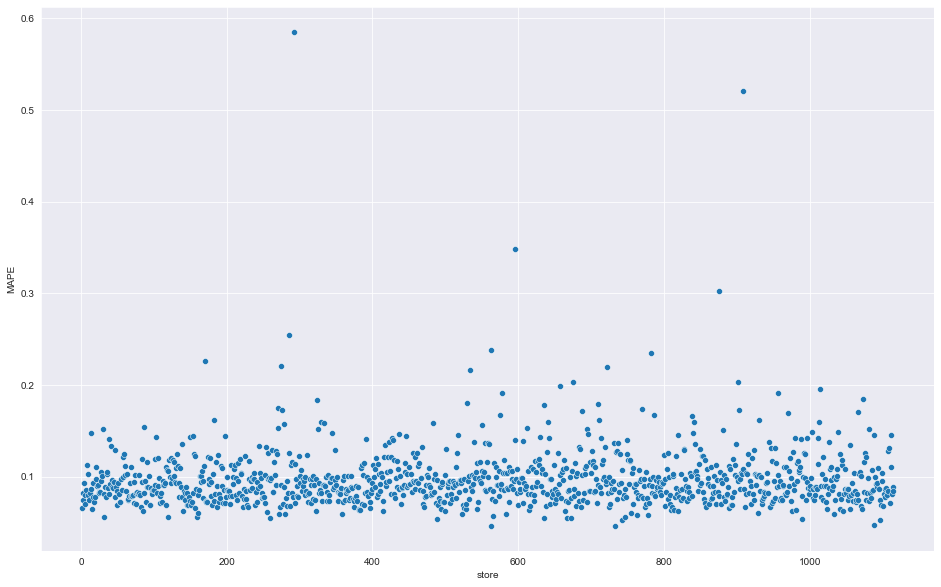

In [236]:
sns.scatterplot('store', 'MAPE', data = df72);

## Total Performance

In [254]:
df73 = pd.DataFrame(df72[['prediction', 'worst_scenario', 'best_scenario']].sum()).rename(columns = {0: 'SUM'})
df73['SUM'] = df73['SUM'].map('R$ {:,.2f}'.format)
df73

,SUM
prediction,"R$ 283,632,000.00"
worst_scenario,"R$ 252,265,798.40"
best_scenario,"R$ 314,998,225.98"


## Machine Learning Performance

In [255]:
df7['error'] = df7['sales'] - df7['prediction']
df7['error_rate'] = df7['prediction'] / df7['sales'] 

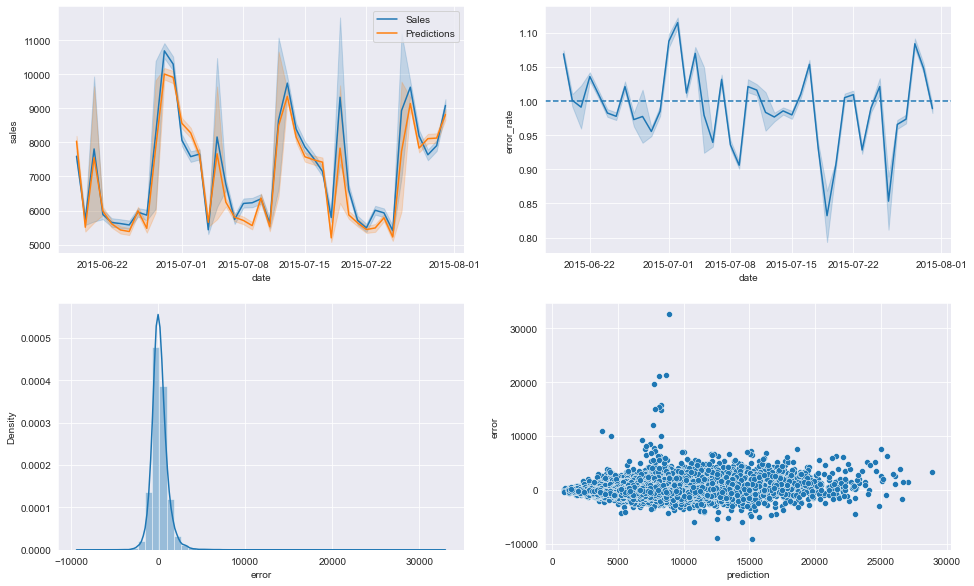

In [258]:
plt.subplot(2, 2, 1)
sns.lineplot('date', 'sales', data = df7, label = 'Sales')
sns.lineplot('date', 'prediction', data = df7, label = 'Predictions')

plt.subplot(2, 2, 2)
sns.lineplot('date', 'error_rate', data = df7)
plt.axhline(1, linestyle = '--')

plt.subplot(2, 2, 3)
sns.distplot(df7['error'])

plt.subplot(2, 2, 4)
sns.scatterplot('prediction', 'error', data = df7);

# Deploy Model to Production

In [ ]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('C:\\Users\\felip\\repos\\data_science_em_producao\\Model\\model_rossmann.pkl', 'wb'))

## Rossman Class

In [277]:
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open('C:\\Users\\felip\\repos\\data_science_em_producao\\Parameter\\store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # Rename columns
        df1.columns = cols_new

        df1['date'] = pd.to_datetime(df1['date'])

        ## Fillout NaN
        # Competition Distance
        df1['competition_distance'].fillna(200000, inplace = True)

        # competition_open_since_month
        df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace = True)

        #competition_open_since_year    
        df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace = True)

        #promo2_since_week   
        df1['promo2_since_week'].fillna(df1['date'].dt.week, inplace = True)

        #promo2_since_year     
        df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        ## Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    
    def feature_enginnering(self, df2):
        # year
        df2['year'] = df2.date.dt.year

        # month
        df2['month'] = df2.date.dt.month

        # day
        df2['day'] = df2.date.dt.day

        # week of year
        df2['week_of_year'] = df2.date.dt.weekofyear

        # year week
        df2['year_week'] = df2.date.dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## Rows Filtering
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## Columns Filtering
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    
    def data_preparation(self, df5):
        
        # Competition Distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(num_var[['competition_distance']].values)
    
        # Competition Time Month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(num_var[['competition_time_month']].values)
        
        # Promo Time Week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(num_var[['promo_time_week']].values)
        
        # Year
        df5['year'] = self.year_scaler.fit_transform(num_var[['year']].values)

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['st_holiday'], columns = ['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

        # month
        df5['month_sin'] = df5.month.apply(lambda x: np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5.month.apply(lambda x: np.cos(x * (2 * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos',
                         'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin']
        
        return df5[cols_selected]

## API Handler

## API Tester